Problem: Instacart faces a profit growth challenge due to suboptimal customer engagement and retention. Current personalization efforts underutilize rich transactional data, limiting the delivery of tailored shopping experiences and constraining revenue potential.

Objective: Unlock revenue potential by boosting customer engagement and retention through personalized offerings.

Opportunity: apitalize on robust historical data to drive targeted marketing, optimize inventory, and improve operational efficiency.

Strategy: Use enterprise analytics to accelerate innovation and fuel business growth. 



In [1]:
# Standard Library
import os
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed, parallel_backend
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation / Analysis
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as color
from matplotlib.cm import get_cmap
from IPython.display import display


# mlxtend (Frequent Patterns)
import mlxtend
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Network Analysis
import networkx as nx

# Dimensionality Reduction / Embedding
from sklearn.decomposition import PCA, TruncatedSVD
import umap.umap_ as umap

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Model Training & Evaluation 
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score
)
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)

# Sparse Matrices 
from scipy.sparse import csr_matrix, hstack

# Imbalanced Learning 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# set theme
sns.set_theme(style="white",palette="viridis",
              rc={ # remove spines
              "axes.spines.top":False,
              "axes.spines.right":False,
              "axes.spines.left":False,
              "axes.spines.bottom":False,
              }
        )
# Use Kaggle CLI to download the dataset
!kaggle competitions download -c instacart-market-basket-analysis

# Unzip the dataset into a working directory
!unzip -o instacart-market-basket-analysis.zip -d ./data/

# Unzip each file in the data folder
for file in os.listdir('./data'):
    if file.endswith('.zip'):
        os.system(f'unzip -o ./data/{file} -d ./data/')

# Load the dataset into our environment
dir_path = './data'
order_products_train = pd.read_csv(f'{dir_path}/order_products__train.csv')
order_products_prior = pd.read_csv(f'{dir_path}/order_products__prior.csv')
orders      = pd.read_csv(f'{dir_path}/orders.csv')
products    = pd.read_csv(f'{dir_path}/products.csv')
aisles      = pd.read_csv(f'{dir_path}/aisles.csv')
departments = pd.read_csv(f'{dir_path}/departments.csv')

403 - Forbidden - Permission 'competitions.participate' was denied
Archive:  instacart-market-basket-analysis.zip
  inflating: ./data/sample_submission.csv  
Archive:  ./data/orders.csv.zip
  inflating: ./data/orders.csv       
  inflating: ./data/__MACOSX/._orders.csv  
Archive:  ./data/order_products__prior.csv.zip
  inflating: ./data/order_products__prior.csv  
  inflating: ./data/__MACOSX/._order_products__prior.csv  
Archive:  ./data/order_products__train.csv.zip
  inflating: ./data/order_products__train.csv  
  inflating: ./data/__MACOSX/._order_products__train.csv  
Archive:  ./data/sample_submission.csv.zip
  inflating: ./data/sample_submission.csv  
Archive:  ./data/departments.csv.zip
  inflating: ./data/departments.csv  
  inflating: ./data/__MACOSX/._departments.csv  
Archive:  ./data/products.csv.zip
  inflating: ./data/products.csv     
  inflating: ./data/__MACOSX/._products.csv  
Archive:  ./data/aisles.csv.zip
  inflating: ./data/aisles.csv       
  inflating: ./data/_

# Data Pre-Processing

In [2]:
print(order_products_train.info()) # check data types

num_missing_values = order_products_train.isna().sum().sum() # check for missing values

print("There are", num_missing_values, "missing values")

order_products_train.head(2) # inspect data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB
None
There are 0 missing values


order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1

In [3]:
print(order_products_prior.info()) # check data types

num_missing_values = order_products_prior.isna().sum().sum() # check for missing values

print("There are", num_missing_values, "missing values")

order_products_prior.head(2) # inspect data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB
None
There are 0 missing values


order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1

In [4]:
print(orders.info()) # check data types

num_missing_values = orders.isna().sum().sum() # check for missing values

print("There are", num_missing_values, "missing values")

orders.head(2) # inspect data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
None
There are 206209 missing values


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   

   days_since_prior_order  
0                     NaN  
1                    15.0

In [5]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

The days_since_prior_order column contains 206209 missing values, which,according to the data description, occurs when orderNumber = 1. We will confirm this alignment in the next step.  

In [6]:
# check alignment of missing values to ordernumber=1
subset = orders[(orders["order_number"]==1) & (orders["days_since_prior_order"].isna())]
subset.describe()

order_id        user_id  order_number      order_dow  \
count  2.062090e+05  206209.000000      206209.0  206209.000000   
mean   1.708462e+06  103105.000000           1.0       2.754118   
std    9.881299e+05   59527.555167           0.0       2.076205   
min    2.000000e+01       1.000000           1.0       0.000000   
25%    8.507300e+05   51553.000000           1.0       1.000000   
50%    1.706246e+06  103105.000000           1.0       3.000000   
75%    2.564292e+06  154657.000000           1.0       5.000000   
max    3.421081e+06  206209.000000           1.0       6.000000   

       order_hour_of_day  days_since_prior_order  
count      206209.000000                     0.0  
mean           13.626597                     NaN  
std             4.223769                     NaN  
min             0.000000                     NaN  
25%            11.000000                     NaN  
50%            14.000000                     NaN  
75%            17.000000                     NaN  
max            23.000000                     NaN

All missing values in the days_since_prior_order column contain order_number=1.

### Feature Engineering

Days of the week are represented as integer values and not easily interpretable. We will map the integers to their corresponding day names and store in a categorical column. 

In [7]:
# Map days and hours to cateogrical features
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}

orders['order_dow'] = orders['order_dow'].replace(to_replace=days_of_week) # replace dow with new values

# convert dow string values into categorical columns
orders['order_dow'] = pd.Categorical(orders['order_dow'], 
                                     ordered=True, 
                                     categories=list(days_of_week.values()))
orders['order_hour_of_day'] = pd.to_datetime(orders['order_hour_of_day'],format='%H').dt.strftime('%-I:%M%p')

# Convert to categorical and order by AM/PM designation
time_order = [
    f"{hour % 12 or 12}:00{'AM' if hour < 12 else 'PM'}"
    for hour in range(24)
]

orders['order_hour_of_day'] = pd.Categorical(
    orders['order_hour_of_day'], 
    categories=time_order, 
    ordered=True
)


In [8]:
orders.head(10)

order_id  user_id eval_set  order_number  order_dow order_hour_of_day  \
0   2539329        1    prior             1     Monday            8:00AM   
1   2398795        1    prior             2    Tuesday            7:00AM   
2    473747        1    prior             3    Tuesday           12:00PM   
3   2254736        1    prior             4  Wednesday            7:00AM   
4    431534        1    prior             5  Wednesday            3:00PM   
5   3367565        1    prior             6     Monday            7:00AM   
6    550135        1    prior             7     Sunday            9:00AM   
7   3108588        1    prior             8     Sunday            2:00PM   
8   2295261        1    prior             9     Sunday            4:00PM   
9   2550362        1    prior            10  Wednesday            8:00AM   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
5                    19.0  
6                    20.0  
7                    14.0  
8                     0.0  
9                    30.0

In [9]:
print(products.info()) # check data types

num_missing_values = products.isna().sum().sum() # check for missing values

print("There are", num_missing_values, "missing values")

products.head(2) # inspect data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
There are 0 missing values


product_id                product_name  aisle_id  department_id
0           1  Chocolate Sandwich Cookies        61             19
1           2            All-Seasons Salt       104             13

In [10]:
print(aisles.info()) # check data types

num_missing_values = aisles.isna().sum().sum() # check for missing values

print("There are", num_missing_values, "missing values")

aisles.head(2) # inspect data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None
There are 0 missing values


aisle_id                  aisle
0         1  prepared soups salads
1         2      specialty cheeses

In [11]:
print(departments.info()) # check data types

num_missing_values = departments.isna().sum().sum() # check for missing values

print("There are", num_missing_values, "missing values")

departments.head(2) # inspect data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes
None
There are 0 missing values


department_id department
0              1     frozen
1              2      other

All data values are categorized appropriately. Next, we combine the dataframes. 

In [12]:
full_products = products.copy()
full_products = pd.merge(full_products, aisles,               on='aisle_id',      how='left')
full_products = pd.merge(full_products, departments,          on='department_id', how='left')
order_products_train = pd.merge(order_products_train, orders, on='order_id',      how='left')
order_products_prior = pd.merge(order_products_prior, orders, on='order_id',      how='left')
train         = pd.merge(order_products_train, full_products, on='product_id',    how='left')
test          = pd.merge(order_products_prior, full_products, on='product_id',    how='left')

In [13]:
train.head(2) # check merging of data

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         1       49302                  1          1   112108    train   
1         1       11109                  2          1   112108    train   

   order_number  order_dow order_hour_of_day  days_since_prior_order  \
0             4  Wednesday           10:00AM                     9.0   
1             4  Wednesday           10:00AM                     9.0   

                                    product_name  aisle_id  department_id  \
0                               Bulgarian Yogurt       120             16   
1  Organic 4% Milk Fat Whole Milk Cottage Cheese       108             16   

                  aisle  department  
0                yogurt  dairy eggs  
1  other creams cheeses  dairy eggs

In [14]:
train.shape
#test.shape

(1384617, 15)

In [15]:
orders.head()

order_id  user_id eval_set  order_number  order_dow order_hour_of_day  \
0   2539329        1    prior             1     Monday            8:00AM   
1   2398795        1    prior             2    Tuesday            7:00AM   
2    473747        1    prior             3    Tuesday           12:00PM   
3   2254736        1    prior             4  Wednesday            7:00AM   
4    431534        1    prior             5  Wednesday            3:00PM   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

### Summary visualizations

In [16]:
num_orders = orders['order_id'].nunique()
order_sizes = orders.groupby('order_id').size()
order_sizes = order_products_prior.groupby('order_id').size()
avg_order_size = order_sizes.mean()
median_order_size = order_sizes.median()

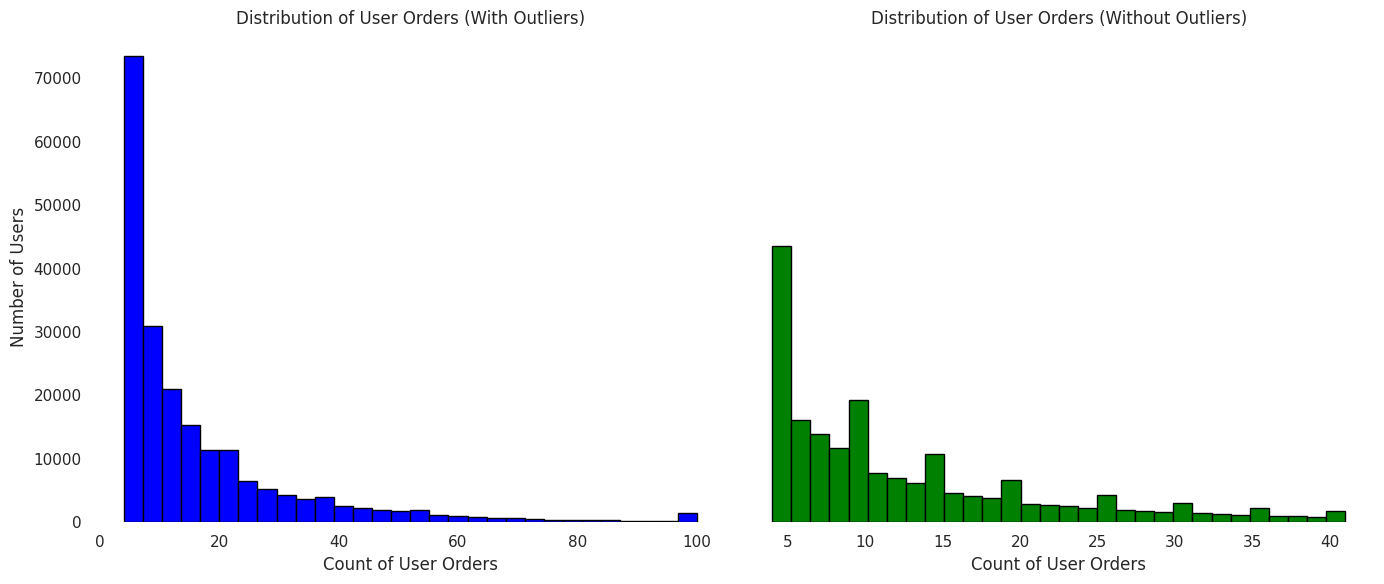

<Figure size 640x480 with 0 Axes>

In [17]:
# Outlier removal

user_orders = orders.groupby('user_id')['order_id'].nunique().reset_index()

user_orders.columns = ['user_id', 'order_count']  # Rename columns for clarity

# Calculate IQR
Q1 = user_orders['order_count'].quantile(0.25)
Q3 = user_orders['order_count'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
user_orders_no_outliers = user_orders[
    (user_orders['order_count'] >= lower_bound) & 
    (user_orders['order_count'] <= upper_bound)
]

# Plot with outliers
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax[0].hist(user_orders['order_count'], bins=30, color='blue', edgecolor='black')
ax[0].set_title("Distribution of User Orders (With Outliers)")
ax[0].set_xlabel("Count of User Orders")
ax[0].set_ylabel("Number of Users")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Plot without outliers
ax[1].hist(user_orders_no_outliers['order_count'], bins=30, color='green', edgecolor='black')
ax[1].set_title("Distribution of User Orders (Without Outliers)")
ax[1].set_xlabel("Count of User Orders")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

user_orders_no_outliers.to_csv("user_orders_no_outliers.csv", index=False)
plt.savefig("bar_graph.png", dpi=300, bbox_inches='tight')


In [18]:
# comparative analysis 

summary_no_outliers = user_orders_no_outliers['order_count'].describe()
summary_with_outliers = user_orders['order_count'].describe()
perc_outliers = (user_orders_no_outliers['order_count'] / user_orders['order_count']) * 10
print("Summary with outliers")
print(summary_with_outliers,end="\n\n")
print("Summary without outliers")
print(summary_no_outliers,end="\n\n")
print("Percentage of outliers")
print(round(perc_outliers,2))



Summary with outliers
count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_count, dtype: float64

Summary without outliers
count    189192.000000
mean         12.577144
std           8.908718
min           4.000000
25%           6.000000
50%           9.000000
75%          17.000000
max          41.000000
Name: order_count, dtype: float64

Percentage of outliers
0         10.0
1         10.0
2         10.0
3         10.0
4         10.0
          ... 
206204    10.0
206205     NaN
206206    10.0
206207     NaN
206208    10.0
Name: order_count, Length: 206209, dtype: float64


Removing outliers narrowed the data distribution and refined the mean. The median remained largely unchanged providing strong evidence that it's the most reliable measure of central tendency.

**Treatment of Outliers**

Our primary objective is to determine which previously purchased products are likely to appear in future customer orders, while also identifying trends and uncovering key patterns. Although 9.17% of our orders qualify as anomalies, we’ve decided to retain them. These outliers could reveal unique customer behaviors, niche preferences, or valuable insights that might otherwise be missed.

## Data Understanding

In this section, we will conduct an in-depth exploration of orders and products to discover customer behaviors, preferences and actionable insights. 

In [19]:
# compute avg and median orders by day
avg_orders_by_day = orders.groupby('order_dow')['order_id'].nunique().mean()
median_orders_by_day = orders.groupby('order_dow')['order_id'].nunique().median()

In [20]:
# Filter out NaN values
filtered_orders = orders[pd.notna(orders['days_since_prior_order'])]

# Compute average and median time between orders
avg_time_between_orders = filtered_orders.groupby('user_id')['days_since_prior_order'].mean().mean()
median_time_between_orders = filtered_orders.groupby('user_id')['days_since_prior_order'].median().median()

In [21]:
# define metrics
metrics = {
    "Num Orders": [num_orders],
    "Median Order Size": [median_order_size],
    "Median Number Orders per User" : [10.0],
    "Median QTY of Orders per Day" : [median_orders_by_day],
    "Median Time(Days) between Orders": [median_time_between_orders]
}

# convert metrics to DF
metrics_df = pd.DataFrame(metrics)


# clean DF formatting
display(metrics_df.style.set_caption("Order Metrics Summary").set_table_styles(
    [{'selector': 'caption',
      'props': [('text-align', 'center'), ('font-size', '16px'), ('font-weight', 'bold')]}]
).format(precision=0))  # adjust precision to remove decimal points 

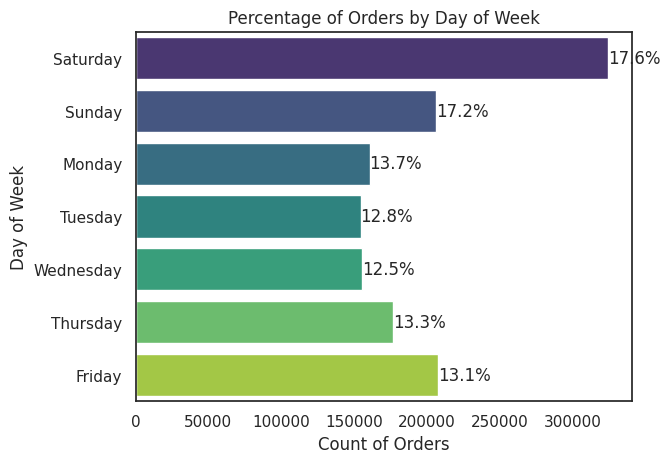

In [22]:
# Calculate percentage of orders by day of week 

# Count unique order_id for each order_dow
order_counts = orders.groupby('order_dow')['order_id'].nunique()

# Normalize to percentages
order_perc = (order_counts / order_counts.sum()) * 100

order_counts = order_counts.sort_index()  # Ensure proper order

# Plot the countplot with no edges
sns.set_theme(style="white")
palette = sns.color_palette("viridis", n_colors=order_counts.size)
ax = sns.countplot(data=train, y='order_dow', palette=palette, edgecolor=None)

# Annotate with percentages
for p, percentage in zip(ax.patches, order_perc):
    width = p.get_width()
    ax.text(width + 0.5,
            p.get_y() + p.get_height() / 2,
            f'{percentage:.1f}%',
            va='center')

# Add labels and title
plt.xlabel('Count of Orders')
plt.ylabel('Day of Week')
plt.title('Percentage of Orders by Day of Week')
plt.show()


# Create a DataFrame from the results
export_df = pd.DataFrame({
    'order_dow': order_counts.index,
    'order_count': order_counts.values,
    'order_perc': order_perc.values
})

export_df.to_csv("orders_by_day.csv", index=False)



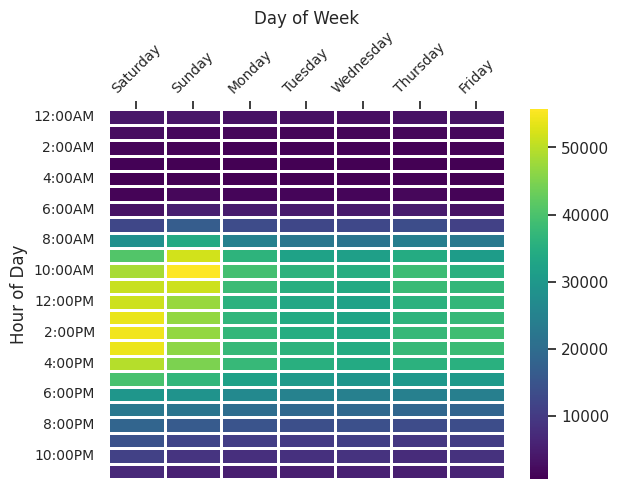

In [23]:
# Calculate orders by time of day
aggregated_data = orders.groupby(["order_dow", "order_hour_of_day"])["order_id"].nunique().reset_index()

# Pivot data for heatmap
heatmap_data = aggregated_data.pivot_table(columns="order_dow", index="order_hour_of_day", values="order_id")

# Export the heatmap data to a CSV file
heatmap_data.to_csv("heatmap_data.csv", index=True)

# Create the heatmap using seaborn
ax = sns.heatmap(heatmap_data, linewidth=.75, cmap="viridis", annot_kws={"size": 9})
ax.xaxis.tick_top()
plt.xticks(fontsize=10, rotation=45)  # adjust font size and rotate for readability
plt.yticks(fontsize=10)
plt.ylabel("Hour of Day", fontsize=12)
ax.xaxis.set_label_position('top')  # align xaxis title to the top
plt.xlabel("Day of Week", fontsize=12)

# Save the heatmap as a vector file (SVG format)
plt.savefig("heatmap.svg", format="svg", bbox_inches="tight")


In [24]:
# extract the numeric part of the index as a Series
heatmap_data.index = heatmap_data.index.astype(str).str.extract('(\d+)')[0].astype(int)

# create AM/PM list 
am_pm = ['AM'] * 12 + ['PM'] * 12  

# map 12-hour to 24-hour format
hour_24 = [
    hour if am_pm[idx] == 'AM' and hour != 12 else 
    (hour if am_pm[idx] == 'PM' and hour == 12 else hour + 12) 
    for idx, hour in enumerate(heatmap_data.index)
]

# replace index with 24-hour format
heatmap_data.index = hour_24

# calculate total orders
total_orders = heatmap_data.sum().sum()

# filter data for 10 AM to 5 PM (peak hours)
peak_demand_data = heatmap_data.loc[10:17]
peak_demand_total_orders = peak_demand_data.sum().sum()

# calculate percentage of orders during peak hours
percentage_of_filtered_orders = (peak_demand_total_orders / total_orders) * 100

# display results
print(f"Total orders: {total_orders}")
print(f"Filtered total orders (10 AM to 5 PM): {peak_demand_total_orders}")
print(f"Percentage of total orders during peak hours: {percentage_of_filtered_orders:.2f}%")

Total orders: 3421083.0
Filtered total orders (10 AM to 5 PM): 2192015.0
Percentage of total orders during peak hours: 64.07%


<>:2: DeprecationWarning: invalid escape sequence '\d'
<>:2: DeprecationWarning: invalid escape sequence '\d'
/var/tmp/ipykernel_3315/4065048695.py:2: DeprecationWarning: invalid escape sequence '\d'
  heatmap_data.index = heatmap_data.index.astype(str).str.extract('(\d+)')[0].astype(int)


In [25]:
# determine % of peak demand orders by day

percentage_of_filtered_orders = (peak_demand_data.sum() / total_orders) * 100
percentage_of_filtered_orders = round(percentage_of_filtered_orders,2)

# determine % of daily orders occuring during peak hours 

perc_orders_peak_hours = round(peak_demand_data.sum() / heatmap_data.sum(),2)*100 # (*100) places columns on same scale as total orders

metrics = {
    "perc_total_orders_peak_hours": [percentage_of_filtered_orders],
    "perc_daily_orders_peak_hours": [perc_orders_peak_hours]
}

# add metrics to DF
metrics_df = pd.DataFrame({
    "Day of Week": percentage_of_filtered_orders.index,  
    "perc_total_orders_peak_hours": percentage_of_filtered_orders,
    "perc_daily_orders_peak_hours": perc_orders_peak_hours
}).set_index("Day of Week")

# display Df
metrics_summary = metrics_df.style.set_caption("Order Metrics Summary by Day of Week").set_table_styles(
    [{'selector': 'caption',
      'props': [('text-align', 'center'), ('font-size', '16px'), ('font-weight', 'bold')]}]
).format(precision=2)

display(metrics_summary)

In [26]:
order_products_prior = pd.merge(order_products_prior,full_products, on='product_id',how='left')

In [27]:
order_products_prior.head()

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
4         2       30035                  5          0   202279    prior   

   order_number order_dow order_hour_of_day  days_since_prior_order  \
0             3  Thursday            9:00AM                     8.0   
1             3  Thursday            9:00AM                     8.0   
2             3  Thursday            9:00AM                     8.0   
3             3  Thursday            9:00AM                     8.0   
4             3  Thursday            9:00AM                     8.0   

            product_name  aisle_id  department_id               aisle  \
0     Organic Egg Whites        86             16                eggs   
1  Michigan Organic Kale        83              4    fresh vegetables   
2          Garlic Powder       104             13   spices seasonings   
3         Coconut Butter        19             13       oils vinegars   
4      Natural Sweetener        17             13  baking ingredients   

   department  
0  dairy eggs  
1     produce  
2      pantry  
3      pantry  
4      pantry

In [28]:
total_products = order_products_prior['product_id'].count()
unique_products = order_products_prior['product_id'].nunique()
order_sizes = order_products_prior.groupby('order_id').size()


metrics_df = {
    "Total Products": [total_products],
    "Unique Products": [unique_products]
}
# convert metrics to DF
metrics_df = pd.DataFrame(metrics_df)

# display DF
display(metrics_df.style.set_caption("Product Metrics Summary").set_table_styles(
    [{'selector': 'caption',
      'props': [('text-align', 'center'), ('font-size', '16px'), ('font-weight', 'bold')]}]
).format(precision=0))  

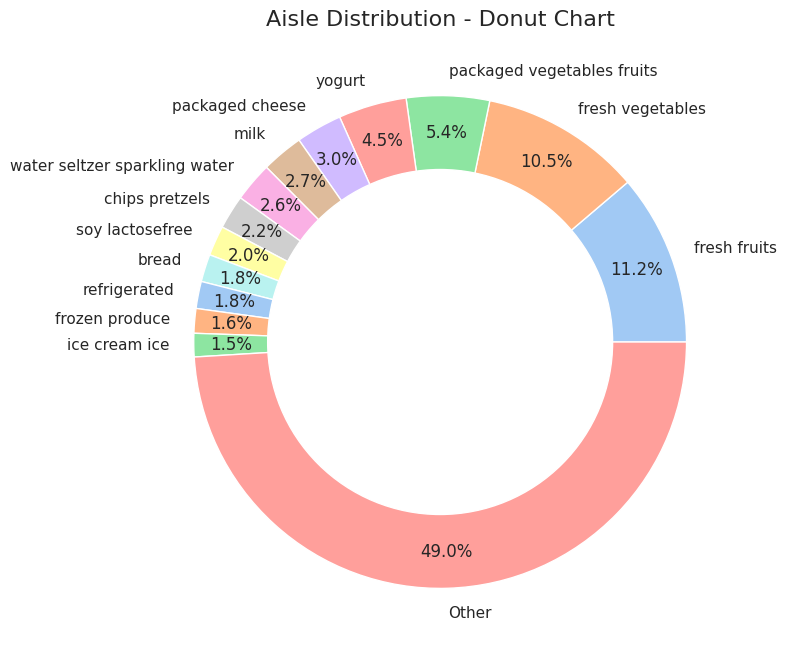

In [29]:
# Create proportions by aisle
proportions = order_products_prior['aisle'].value_counts(normalize=True) * 100

# Define threshold for filtering 
threshold = 1.5

# Apply filtering
filtered_proportions = proportions[proportions >= threshold]

# Add "Other" for smaller categories
filtered_proportions['Other'] = proportions[proportions < threshold].sum()

# Export 
filtered_proportions.to_csv("aisle_distribution_data.csv", header=True)

# Create donut chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    filtered_proportions.values,
    labels=filtered_proportions.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel', len(filtered_proportions)),
    pctdistance=0.85
)


plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))

# Set title
plt.title('Aisle Distribution - Donut Chart', fontsize=16)

# Save as a vector file
plt.savefig("aisle_distribution.svg", format="svg", bbox_inches="tight")
plt.show()

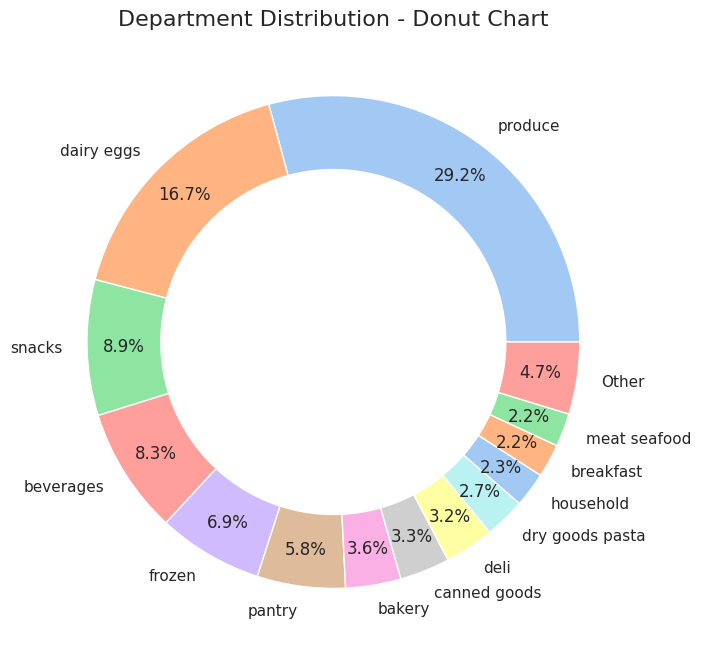

In [30]:
# Create proportions by department
proportions = order_products_prior['department'].value_counts(normalize=True) * 100

# Define threshold for filtering 
threshold = 1.5

# Apply filtering
filtered_proportions = proportions[proportions >= threshold]

# Add "Other" for smaller categories
filtered_proportions['Other'] = proportions[proportions < threshold].sum()

# Export 
filtered_proportions.to_csv("department_distribution_data.csv", header=True)

# Create donut chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    filtered_proportions.values,
    labels=filtered_proportions.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel', len(filtered_proportions)),
    pctdistance=0.85
)


plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))

# Set title
plt.title('Department Distribution - Donut Chart', fontsize=16)

# Save as a vector file
plt.savefig("department_distribution.svg", format="svg", bbox_inches="tight")
plt.show()

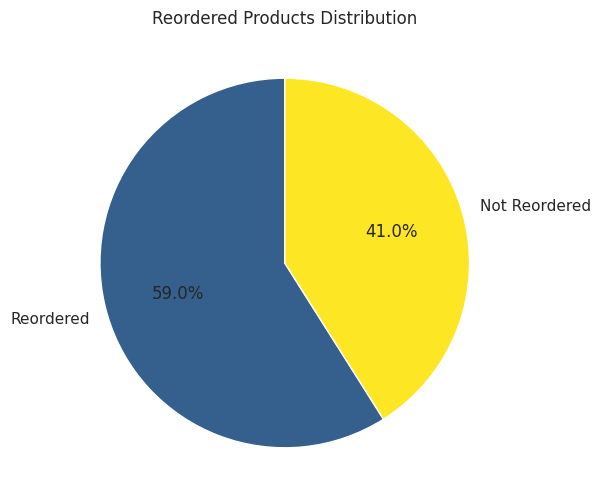

In [31]:
# aggregate
reordered_counts = order_products_prior['reordered'].value_counts()

# map binary values to custom labels
label_mapping = {0: 'Not Reordered', 1: 'Reordered'}
custom_labels = [label_mapping[value] for value in reordered_counts.index]

# pie chart
fig, ax = plt.subplots(figsize=(6, 6))

# Sample colors from viridis starting at 0.3 to avoid dark purple hues
colors = plt.cm.viridis(np.linspace(0.3, 1, len(custom_labels)))
ax.pie(reordered_counts, labels=custom_labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax.set_title('Reordered Products Distribution')

# Save as vector file
plt.savefig("reordered_distribution.svg", format="svg", bbox_inches="tight")

plt.show()

In [32]:
# group by reordered and product_name
grouped = order_products_prior.groupby(['reordered', 'product_name']).size().reset_index(name='count')

# filter for reordered products
reordered_group = grouped[grouped['reordered'] == 1]

# sort by count
most_reordered_products = reordered_group.sort_values(by='count', ascending=False)

# display the top products
print(most_reordered_products.head(20))

       reordered              product_name   count
52924          1                    Banana  398609
52735          1    Bag of Organic Bananas  315913
78756          1      Organic Strawberries  205845
75828          1      Organic Baby Spinach  186884
77209          1      Organic Hass Avocado  170131
75793          1           Organic Avocado  134044
79274          1        Organic Whole Milk  114510
69979          1               Large Lemon  106255
78227          1       Organic Raspberries  105409
88812          1              Strawberries   99802
70895          1                     Limes   95768
79353          1      Organic Yellow Onion   79072
76933          1            Organic Garlic   74663
79391          1          Organic Zucchini   72165
60182          1            Cucumber Kirby   67313
76913          1        Organic Fuji Apple   63811
75980          1       Organic Blueberries   62922
51980          1  Apple Honeycrisp Organic   62510
77473          1             Or

In [33]:
# group by reordered and product_name
reordered_products = order_products_prior[order_products_prior['reordered'] == 1]
product_percentages = reordered_products["product_name"].value_counts(normalize=True) * 100

# select the top 20 products
top20 = product_percentages.head(20)

# output the result to a CSV file
top20.to_csv("top20_reordered_products.csv", header=True)


**Association Rules and Frequent Itemsets**

The next stage in data exploration will be employing data mining algorithms to uncover frequent itemsets and develop association rules. To ensure effective analysis, we will first narrow the dataset by concentrating on orders placed during peak hours. This targeted approach captures the datasets' most significant components, allowing us to focus on actionable trends that drive business value.

In [34]:
# convert the categorical time format to 24-hour integer values
order_products_prior['order_hour_numeric'] = pd.to_datetime(
    order_products_prior['order_hour_of_day'], format='%I:%M%p'
).dt.hour

# filter data for peak hours between 10 AM and 5 PM
peak_hours_data_orders_prior = order_products_prior[(order_products_prior['order_hour_numeric'] >= 10) & 
                                       (order_products_prior['order_hour_numeric'] <= 17)]


perc_difference = 1 - (peak_hours_data_orders_prior['order_id'].nunique() / order_products_prior['order_id'].nunique())
perc_difference = round(perc_difference,2) * 100
print(f"We reduced the number of orders by {perc_difference}% by focusing on peak hours")


We reduced the number of orders by 36.0% by focusing on peak hours


In [35]:
num_orders = peak_hours_data_orders_prior.groupby("user_id")["order_id"].nunique()

# filter out users using IQR method
q1 = num_orders.quantile(.25)
q3 = num_orders.quantile(.75)
users_in_iqr= num_orders[(num_orders >= q1) & (num_orders <= q3)].index

filtered_data = peak_hours_data_orders_prior[peak_hours_data_orders_prior["user_id"].isin(users_in_iqr)]
filtered_data_summary = filtered_data.groupby("user_id")["order_id"].nunique()

# calculate % differences
perc_difference = 1 - (filtered_data["order_id"].nunique() / peak_hours_data_orders_prior['order_id'].nunique())
perc_difference = round(perc_difference,2)*100
perc_difference_total = 1 - (filtered_data["order_id"].nunique() / order_products_prior['order_id'].nunique())
perc_difference_total = round(perc_difference_total,2)*100

print(filtered_data_summary.describe())
print(f"Our new data frame is {perc_difference}% smaller than the peak hours data for orders prior and {perc_difference_total}% smaller \n than the original order_products_prior dataframe")

count    124996.000000
mean          6.300338
std           2.956035
min           3.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          13.000000
Name: order_id, dtype: float64
Our new data frame is 62.0% smaller than the peak hours data for orders prior and 76.0% smaller 
 than the original order_products_prior dataframe


We reduced the order_products_prior dataframe by 75% by concentrating on high-frequency customers during peak hours. This optimization not only conserves computational resources but also highlights key trends by focusing on the core components of the dataset.

In [36]:
product_counts = filtered_data.groupby("product_id")["order_id"].count().reset_index().rename(columns={'order_id':'frequency'})
top_100_products= product_counts.sort_values('frequency',ascending=False)[0:100]

We refined the dataset by narrowing our focus to the top 100 products, allowing us to uncover the most frequent itemsets and association rules. Since these products are present in a significant proportion of orders, the filtered data remains substantial for data mining. For our purposes, we don’t need the entire dataset, just a good representative sample to elucidate trends while maintaining efficiency. To achieve this, we will compute the product distribution of the top 100 items and apply stratified sampling. This approach optimizes computational resources while maintaining focus on key patterns.

**Product-Level Association Rules**

In [37]:
# Get top 100 product IDs
top_100_products = product_counts['product_id']

# Filter original data for top 100 products
filtered_top_100 = filtered_data[filtered_data['product_id'].isin(top_100_products)]
product_distribution = filtered_top_100["product_id"].value_counts(normalize=True)

In [38]:
# compute product distribution
product_distribution = filtered_top_100['product_id'].value_counts(normalize=True).to_dict()

# sample data based on distribution
sampled_orders = filtered_top_100.sample(
    frac=1,weights=filtered_top_100['product_id'].map(product_distribution), random_state=42
)

# prepare transactions
transactions = sampled_orders.groupby('order_id')['product_name'].apply(list).tolist()

#  apply transaction encoder wth sparse matrix 
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=True)  # use sparse matrix for efficiency
one_hot = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

# run fp-growth on chunks
def run_fpgrowth(chunk):
    return fpgrowth(chunk, min_support=0.005, use_colnames=True)

# split data into chunks
num_cores = 16
chunks = np.array_split(one_hot, num_cores)

# parallel fp-growth
if __name__ == "__main__":
    with mp.Pool(num_cores) as pool:
        results = pool.map(run_fpgrowth, chunks)

    # combine results and remove duplicates
    frequent_itemsets = pd.concat(results, ignore_index=True).drop_duplicates()
    frequent_itemsets = frequent_itemsets.groupby('itemsets', as_index=False).agg({'support': 'mean'})

In [39]:
# Set pandas display options to show full content in columns
pd.set_option('display.max_colwidth', None)  # No truncation for column contents
pd.set_option('display.max_rows', None)     

# Display the DataFrame with unwrapped itemsets
frequent_itemsets_sorted = frequent_itemsets.sort_values(by="support",ascending=False) 
frequent_itemsets_sorted.shape

(350, 2)

In [40]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.4)

# Sort and display rules by lift
rules_sorted = rules.sort_values(by='lift', ascending=False)
filtered_rules = rules_sorted.query("support > .01 and confidence > .07")

# output to csv
filtered_rules.to_csv('filtered_rules.csv', index=False)

filtered_rules

antecedents               consequents  antecedent support  \
79     (Organic Hass Avocado)  (Bag of Organic Bananas)            0.054447   
78   (Bag of Organic Bananas)    (Organic Hass Avocado)            0.099147   
87                   (Banana)          (Cucumber Kirby)            0.139193   
86           (Cucumber Kirby)                  (Banana)            0.033597   
103    (Organic Strawberries)  (Bag of Organic Bananas)            0.066406   
102  (Bag of Organic Bananas)    (Organic Strawberries)            0.099147   
12             (Strawberries)                  (Banana)            0.045259   
13                   (Banana)            (Strawberries)            0.139193   
26                   (Banana)         (Organic Avocado)            0.139193   
27          (Organic Avocado)                  (Banana)            0.058340   
0    (Bag of Organic Bananas)    (Organic Baby Spinach)            0.099147   
1      (Organic Baby Spinach)  (Bag of Organic Bananas)            0.071494   
90              (Large Lemon)                  (Banana)            0.050874   
91                   (Banana)             (Large Lemon)            0.139193   
100    (Organic Strawberries)                  (Banana)            0.066406   
101                  (Banana)    (Organic Strawberries)            0.139193   
3                    (Banana)    (Organic Baby Spinach)            0.139193   
2      (Organic Baby Spinach)                  (Banana)            0.071494   

     consequent support   support  confidence      lift  leverage  conviction  
79             0.099147  0.014232    0.261396  2.636442  0.008834    1.219669  
78             0.054447  0.014232    0.143545  2.636442  0.008834    1.104032  
87             0.033597  0.010301    0.074003  2.202663  0.005624    1.043635  
86             0.139193  0.010301    0.306596  2.202663  0.005624    1.241421  
103            0.099147  0.014173    0.213436  2.152723  0.007590    1.145302  
102            0.066406  0.014173    0.142954  2.152723  0.007590    1.089316  
12             0.139193  0.012717    0.280987  2.018683  0.006417    1.197206  
13             0.045259  0.012717    0.091363  2.018683  0.006417    1.050740  
26             0.058340  0.016327    0.117296  2.010542  0.008206    1.066789  
27             0.139193  0.016327    0.279854  2.010542  0.008206    1.195322  
0              0.071494  0.013593    0.137103  1.917678  0.006505    1.076033  
1              0.099147  0.013593    0.190132  1.917678  0.006505    1.112346  
90             0.139193  0.012638    0.248428  1.784768  0.005557    1.145341  
91             0.050874  0.012638    0.090798  1.784768  0.005557    1.043911  
100            0.139193  0.013807    0.207913  1.493698  0.004563    1.086757  
101            0.066406  0.013807    0.099191  1.493698  0.004563    1.036395  
3              0.071494  0.014510    0.104245  1.458086  0.004559    1.036562  
2              0.139193  0.014510    0.202956  1.458086  0.004559    1.079999

The output above highlights product combinations with strong associations (lift > 1.4), frequent occurrence (support > 0.01), and high confidence (> 0.07). While the support and confidence values may seem low, they are significant in the context of market basket analysis, especially when dealing with a large dataset containing numerous product combinations.

With 3.4 million orders in our original DataFrame, a rule with a support of 0.01 still represents over 3,000 orders. Additionally, confidence may appear lower due to the sheer number of possible product pairings in the dataset. As the number of products increases, so does the number of potential combinations, which dilutes both the support and confidence metrics for individual rules. Despite this, these rules remain meaningful for identifying actionable patterns within a complex dataset.


Interpreting association rules can be challenging, particularly when analyzing large datasets with numerous product combinations. To enhance clarity and aid in interpretation, we will utilize directed graphs to visually display the connections between products.

/var/tmp/ipykernel_3315/3684851909.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


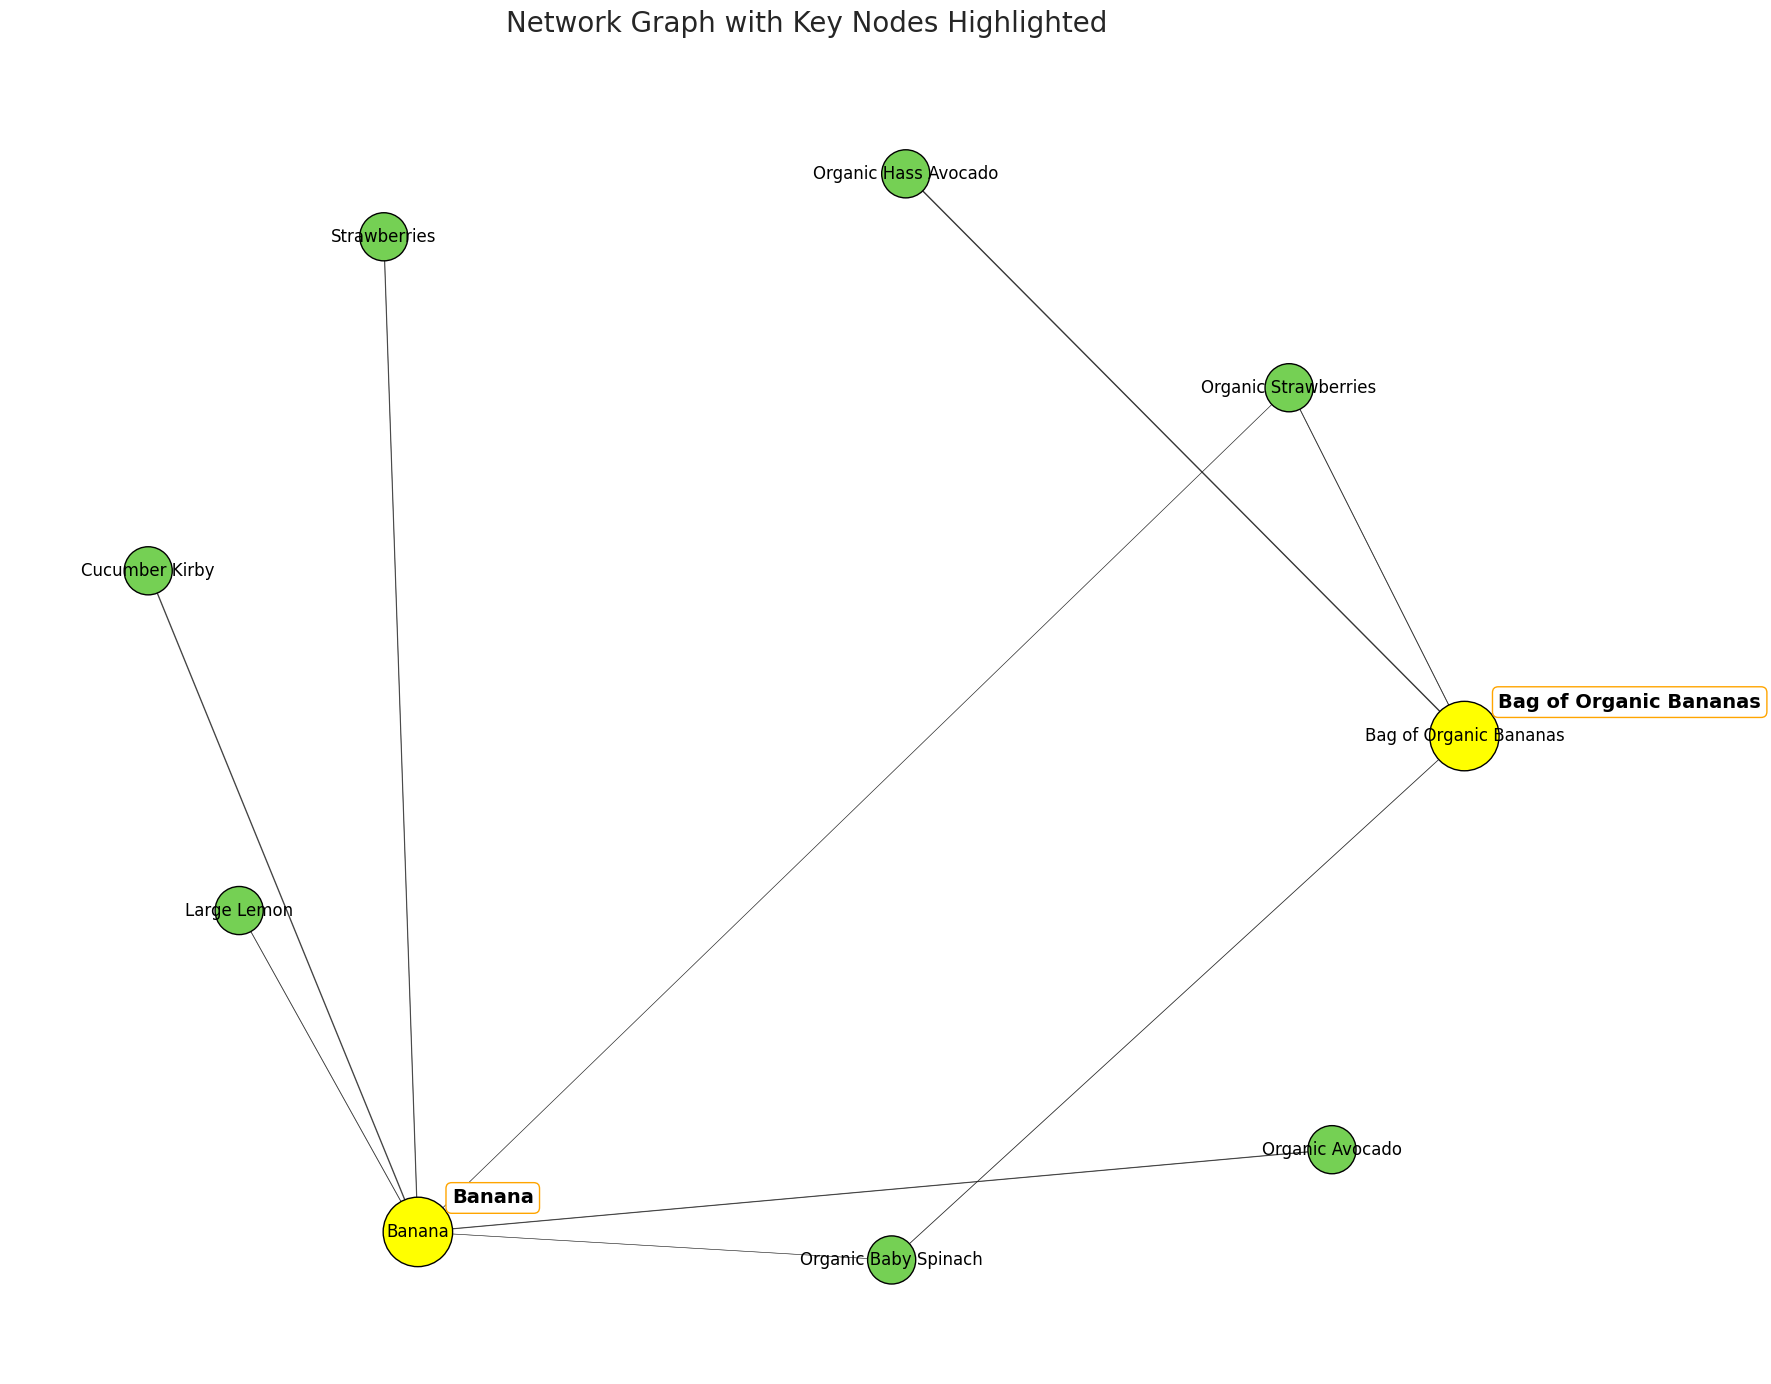

Degree Centrality for Key Nodes:
Bag of Organic Bananas: 0.750
Banana: 1.500


In [41]:
# Create a directed graph
G = nx.DiGraph()
for _, row in filtered_rules.iterrows():
    G.add_edge(
        ', '.join(row['antecedents']),
        ', '.join(row['consequents']),
        weight=row['lift'] * row['confidence'],
        support=row['support']
    )

# Identify key nodes based on degree centrality using the 75th percentile threshold
degree_centrality = nx.degree_centrality(G)
threshold = np.percentile(list(degree_centrality.values()), 75)
key_nodes = {node for node, centrality in degree_centrality.items() if centrality > threshold}

# Use a spring layout for spacing
pos = nx.spring_layout(G, k=3, seed=42)

# Determine node sizes with key nodes emphasized
node_sizes = [2500 if node in key_nodes else 1200 for node in G.nodes()]

# Create a truncated viridis colormap that excludes dark colors
viridis = plt.cm.get_cmap('viridis')
trunc_viridis = color.LinearSegmentedColormap.from_list("trunc_viridis", viridis(np.linspace(0.3, 1.0, 256)))

# Select a uniform light color from the truncated viridis for non-key nodes 
non_key_color = trunc_viridis(0.7)

# Assign colors with key node in yellow
node_colors = ['yellow' if node in key_nodes else non_key_color for node in G.nodes()]

plt.figure(figsize=(18, 14))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=12, font_color='black')

# Draw edges with thinner lines
edges = G.edges(data=True)
edge_widths = [max(0.3, data['weight'] * 1.5) for _, _, data in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, arrowstyle='->', arrowsize=10, alpha=0.7)

# Add callout boxes for key nodes
for node in key_nodes:
    x, y = pos[node]
    plt.text(x + 0.05, y + 0.05, node, fontsize=14, fontweight='bold', color='black',
             bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.3'))

plt.title('Network Graph with Key Nodes Highlighted', fontsize=20, pad=20)
plt.axis('off')
plt.tight_layout()

# Save as vector
plt.savefig("network_graph_products.svg", format="svg", bbox_inches="tight")
plt.show()

print("Degree Centrality for Key Nodes:")
for node in key_nodes:
    print(f"{node}: {degree_centrality[node]:.3f}")

# Export to CSV for use in PPT
# Export nodes
nodes_list = []
for node in G.nodes():
    nodes_list.append({
        'node': node,
        'degree_centrality': degree_centrality[node],
        'is_key_node': node in key_nodes,
        'pos_x': pos[node][0],
        'pos_y': pos[node][1]
    })

df_nodes = pd.DataFrame(nodes_list)
df_nodes.to_csv("network_nodes.csv", index=False)


# Export edges
edges_list = []
for source, target, data in G.edges(data=True):
    edges_list.append({
        'source': source,
        'target': target,
        'weight': data['weight'],
        'support': data['support']
    })

df_edges = pd.DataFrame(edges_list)
df_edges.to_csv("network_edges.csv", index=False)

**Product-Level Insights**

Banana (Organic and Non-Organic) is a pivotal product. Its prominence indicates it is a frequent co-purchase partner with many other items. 

Opportunity: Leverage bananas for targeted promotions, cross-selling, and prime shelf placement to drive overall basket growth. 

**Aisle-Level Association Rules**

In [42]:
# group by 'order_id' within a chunk
def group_chunk(chunk):
    return chunk.groupby('order_id')['aisle'].apply(list)

# split data into chunks
def split_dataframe(df, num_chunks):
    chunk_size = len(df) // num_chunks
    return [df.iloc[i * chunk_size: (i + 1) * chunk_size] for i in range(num_chunks)]

# input number of CPU cores
num_cores = 16

# split the data into chunks
chunks = split_dataframe(filtered_data, num_cores)

# run the groupby operation in parallel
with Pool(num_cores) as pool:
    results = pool.map(group_chunk, chunks)

# combine results from all chunks
final_result = pd.concat(results)

# convert to list of transactions for data mining use
transactions = final_result.tolist()

In [43]:
transactions[0:1] # confirm transactions loaded apppropriately

[['refrigerated', 'laundry', 'air fresheners candles']]

In [44]:
# convert transactions list to a DataFrame in a one-hot encoded format
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_array, columns=te.columns_)

# generate frequent itemsets
frequent_itemsets = fpgrowth(df, min_support=0.05, use_colnames=True)

# display frequent itemsets
print(frequent_itemsets.head())


    support                         itemsets
0  0.129342                   (refrigerated)
1  0.125497                 (frozen produce)
2  0.189623  (water seltzer sparkling water)
3  0.173295                 (chips pretzels)
4  0.095907                    (soft drinks)


In [45]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# sort and display rules by lift
rules_sorted = rules.sort_values(by='lift', ascending=False)
filtered_rules = rules_sorted.query("confidence > 0.50 and lift > 1.5 and support > .01")
filtered_rules.tail()

antecedents                   consequents  \
286   (milk, packaged vegetables fruits)                (fresh fruits)   
342                          (dry pasta)            (fresh vegetables)   
94   (fresh vegetables, soy lactosefree)                (fresh fruits)   
65        (chips pretzels, fresh fruits)  (packaged vegetables fruits)   
287                 (milk, fresh fruits)  (packaged vegetables fruits)   

     antecedent support  consequent support   support  confidence      lift  \
286            0.093250            0.523379  0.073612    0.789411  1.508296   
342            0.074963            0.443777  0.050067    0.667881  1.504990   
94             0.093429            0.523379  0.073544    0.787165  1.504004   
65             0.102973            0.358090  0.055446    0.538449  1.503668   
287            0.136832            0.358090  0.073612    0.537978  1.502353   

     leverage  conviction  
286  0.024807    2.263277  
342  0.016800    1.674767  
94   0.024645    2.239386  
65   0.018572    1.390767  
287  0.024614    1.389349

Business and non-technical personnel will likely rely on aisle and department-level analysis the most, as these higher-level groupings provide clearer insights into overall trends and customer preferences, which are more actionable for strategic decision-making. In contrast, product-level analysis is often more valuable for technical personnel, such as data scientists or inventory managers, who need to drill down into specific product combinations to optimize operations or refine recommendation systems.

To bridge the gap between these perspectives and make the insights more accessible, we will use a bubble heatmap. This visualization highlights key associations by using lift to determine the color and support to define the bubble size, offering a clear and intuitive one-stop view of significant patterns. This approach simplifies complex data, ensuring both business and technical audiences can quickly identify and act on meaningful insights.

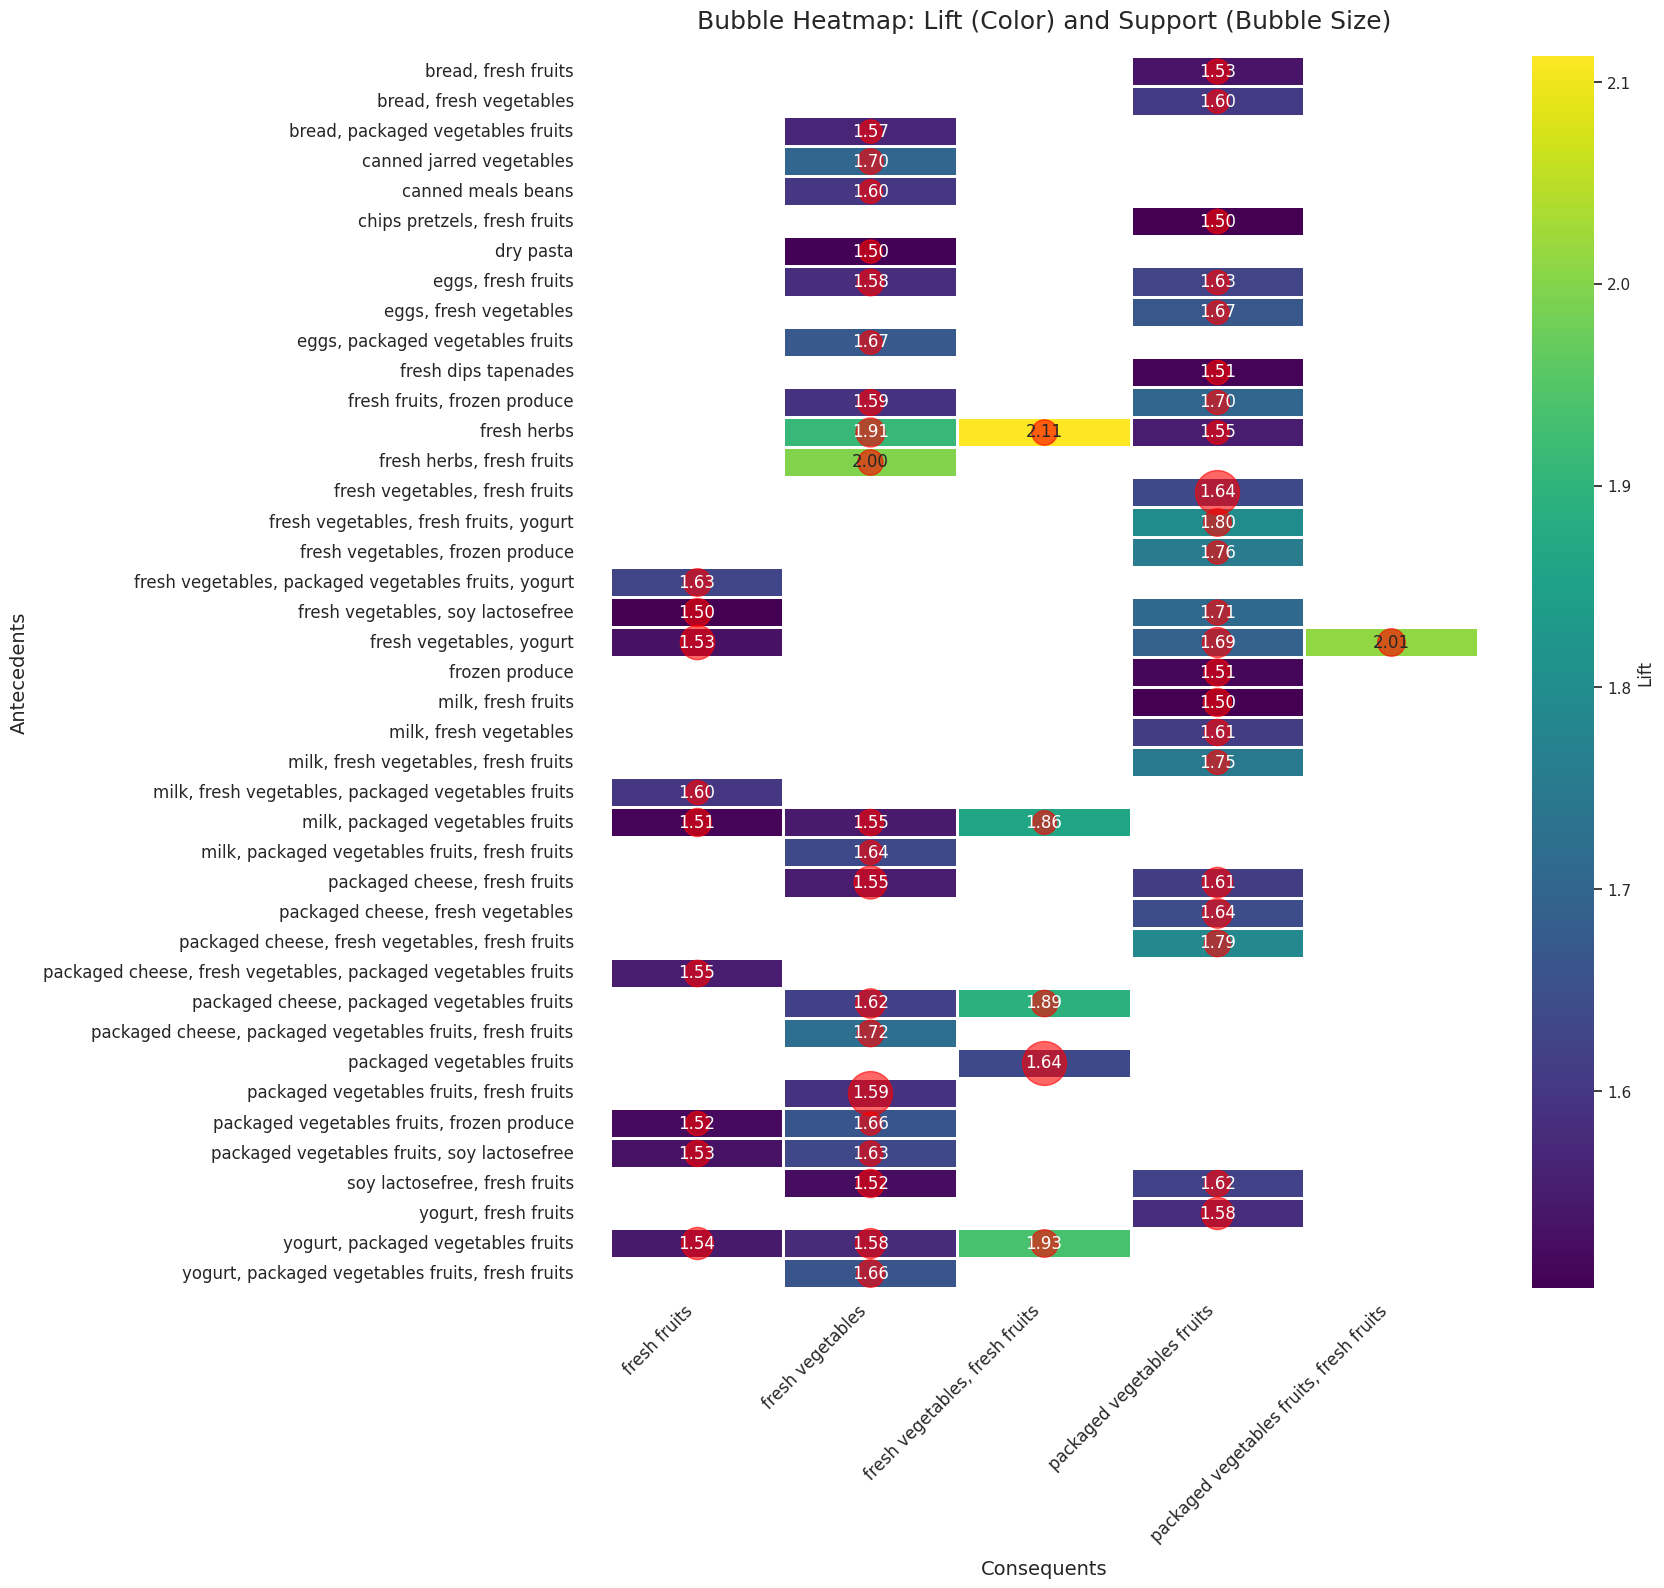

In [46]:
df_rules = pd.DataFrame(filtered_rules, columns=["antecedents", "consequents", "lift", "support"])
df_rules['antecedents'] = df_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
df_rules['consequents'] = df_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Pivot the DataFrame for lift and support
heatmap_data_lift = df_rules.pivot(index='antecedents', columns='consequents', values='lift')
heatmap_data_support = df_rules.pivot(index='antecedents', columns='consequents', values='support')

# Export
heatmap_data_lift.to_csv("heatmap_data_lift.csv", index=True)
heatmap_data_support.to_csv("heatmap_data_support.csv", index=True)

# Normalize support values for bubble sizes (ensure correct scaling)
max_support = heatmap_data_support.max().max()
support_sizes = heatmap_data_support / max_support * 1000  # scale bubble sizes proportional to max support

# Plot the heatmap
fig, ax = plt.subplots(figsize=(14, 16))

# Heatmap for lift
sns.heatmap(
    heatmap_data_lift,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    cbar_kws={'label': 'Lift'},
    ax=ax,
    linewidths=1,
    linecolor='white'
)

# Overlay bubbles for support
for (i, j), lift in np.ndenumerate(heatmap_data_lift.values):
    if not np.isnan(lift):  # avoid plotting bubbles for NaN values
        ax.scatter(j + 0.5, i + 0.5, s=support_sizes.iloc[i, j], color='red', alpha=0.6)

plt.title('Bubble Heatmap: Lift (Color) and Support (Bubble Size)', fontsize=18, pad=20)
plt.xlabel('Consequents', fontsize=14, labelpad=10)
plt.ylabel('Antecedents', fontsize=14, labelpad=10)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Increase y-axis spacing for better readability
ax.set_yticks(np.arange(len(heatmap_data_lift.index)) + 0.5)
ax.set_yticklabels(heatmap_data_lift.index, fontsize=12)
for tick in ax.yaxis.get_major_ticks():
    tick.set_pad(20)

# Save as a vector file
plt.savefig('bubble_heatmap.svg', format='svg', bbox_inches='tight')


plt.show()

# Export
df_rules.to_csv('df_rules.csv', index=False)


/var/tmp/ipykernel_3315/3870928010.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


Total subgraphs: 1


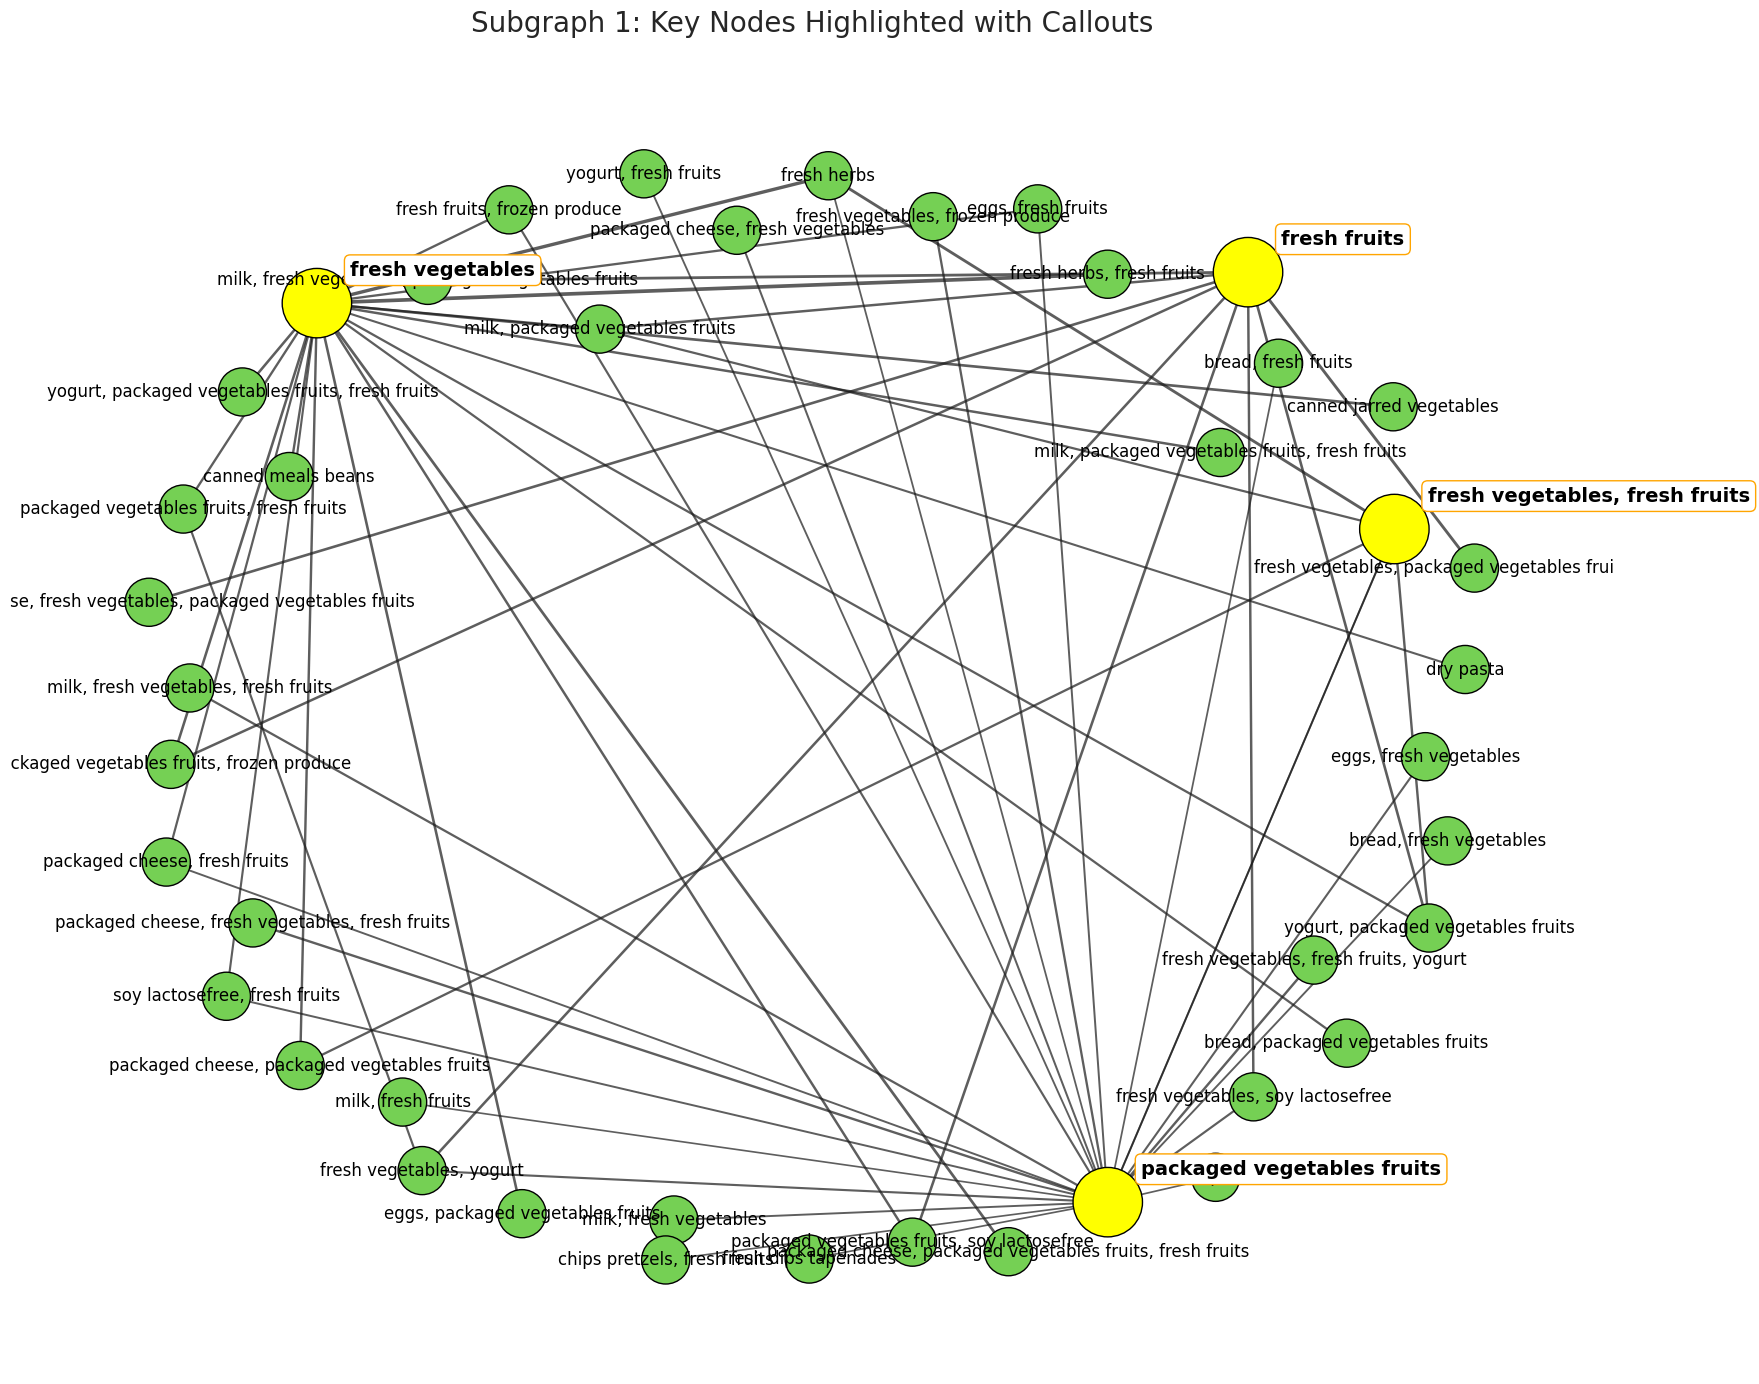

In [47]:
# Create the truncated viridis colormap (excluding the darker end)
viridis = plt.cm.get_cmap('viridis')
trunc_viridis = color.LinearSegmentedColormap.from_list("trunc_viridis", viridis(np.linspace(0.3, 1.0, 256)))
non_key_color = trunc_viridis(0.7)

df_rules = pd.DataFrame(filtered_rules, columns=["antecedents", "consequents", "lift", "support", "confidence"])
df_rules['antecedents'] = df_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
df_rules['consequents'] = df_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# create a directed graph
G = nx.DiGraph()

# add edges to the graph with attributes
for _, row in df_rules.iterrows():
    G.add_edge(
        row['antecedents'], 
        row['consequents'], 
        weight=row['lift'] * row['confidence'],  
        support=row['support']
    )

# identify key nodes based on degree centrality
degree_centrality = nx.degree_centrality(G)
key_nodes = {node for node, centrality in degree_centrality.items() if centrality > 0.1}  

# split into smaller subgraphs
subgraphs = list(nx.connected_components(G.to_undirected()))
print(f"Total subgraphs: {len(subgraphs)}")

# improved visualization for each subgraph
for i, subgraph_nodes in enumerate(subgraphs):
    subgraph = G.subgraph(subgraph_nodes)
    
    # use a spring layout with increased spacing
    pos = nx.spring_layout(subgraph, k=3, seed=42)
    
    # determine node sizes with key nodes emphasized
    node_sizes = [2500 if node in key_nodes else 1200 for node in subgraph.nodes()]
    # assign colors with key node in yellow
    node_colors = ['yellow' if node in key_nodes else non_key_color for node in subgraph.nodes()]
    
    plt.figure(figsize=(18, 14))
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in subgraph.nodes() if node not in key_nodes},
                            font_size=12, font_color='black')  # regular nodes
    
    # draw edges with thinner lines
    edges = subgraph.edges(data=True)
    edge_widths = [max(0.3, data['weight'] * 1.5) for _, _, data in edges]
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, width=edge_widths, arrowstyle='->', arrowsize=10, alpha=0.7)
    
    # add callout boxes for key nodes
    for node in key_nodes:
        if node in pos:
            x, y = pos[node]
            plt.text(x + 0.05, y + 0.05, node, fontsize=14, fontweight='bold', color='black',
                     bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.3'))
    
    plt.title(f'Subgraph {i+1}: Key Nodes Highlighted with Callouts', fontsize=20, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/var/tmp/ipykernel_3315/1129329443.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


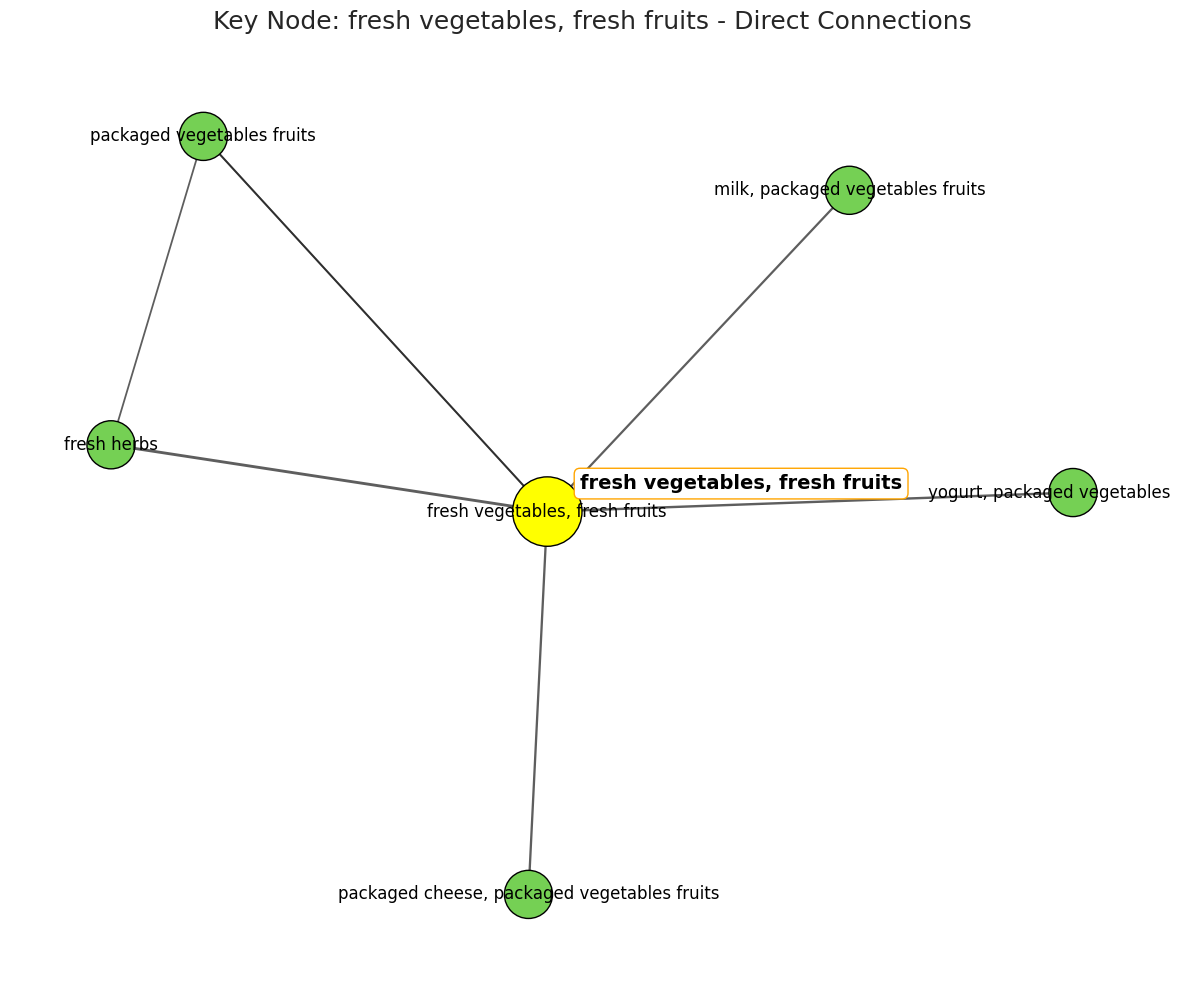

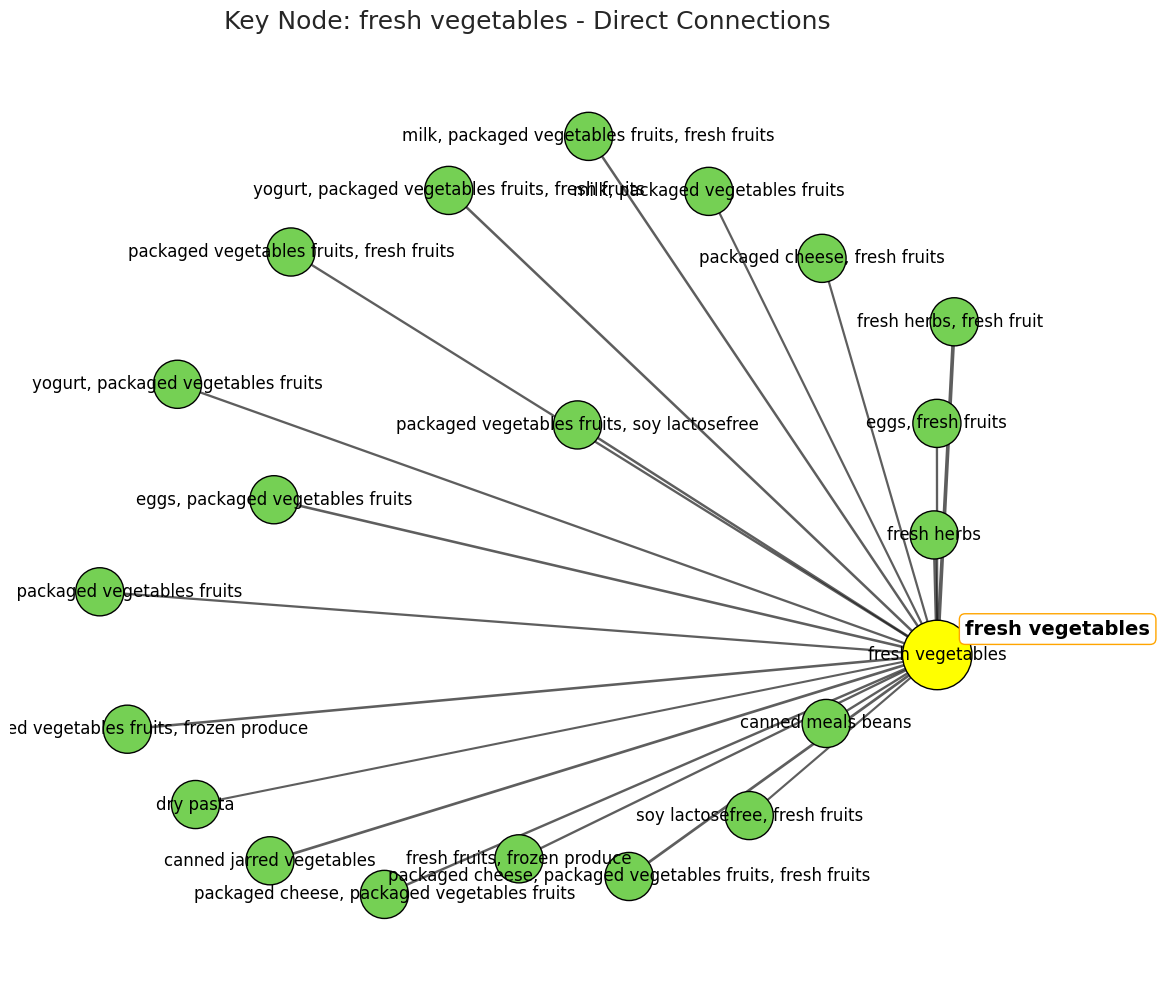

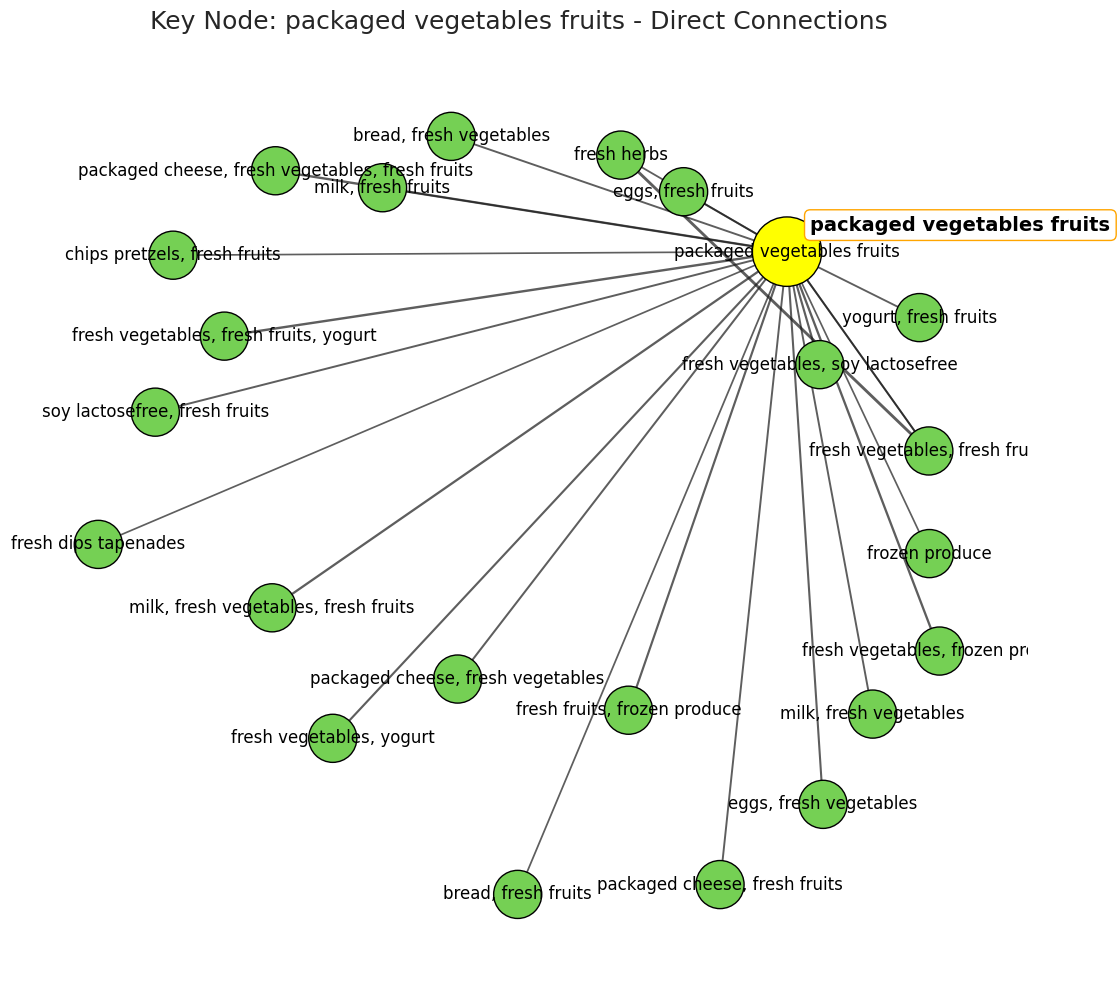

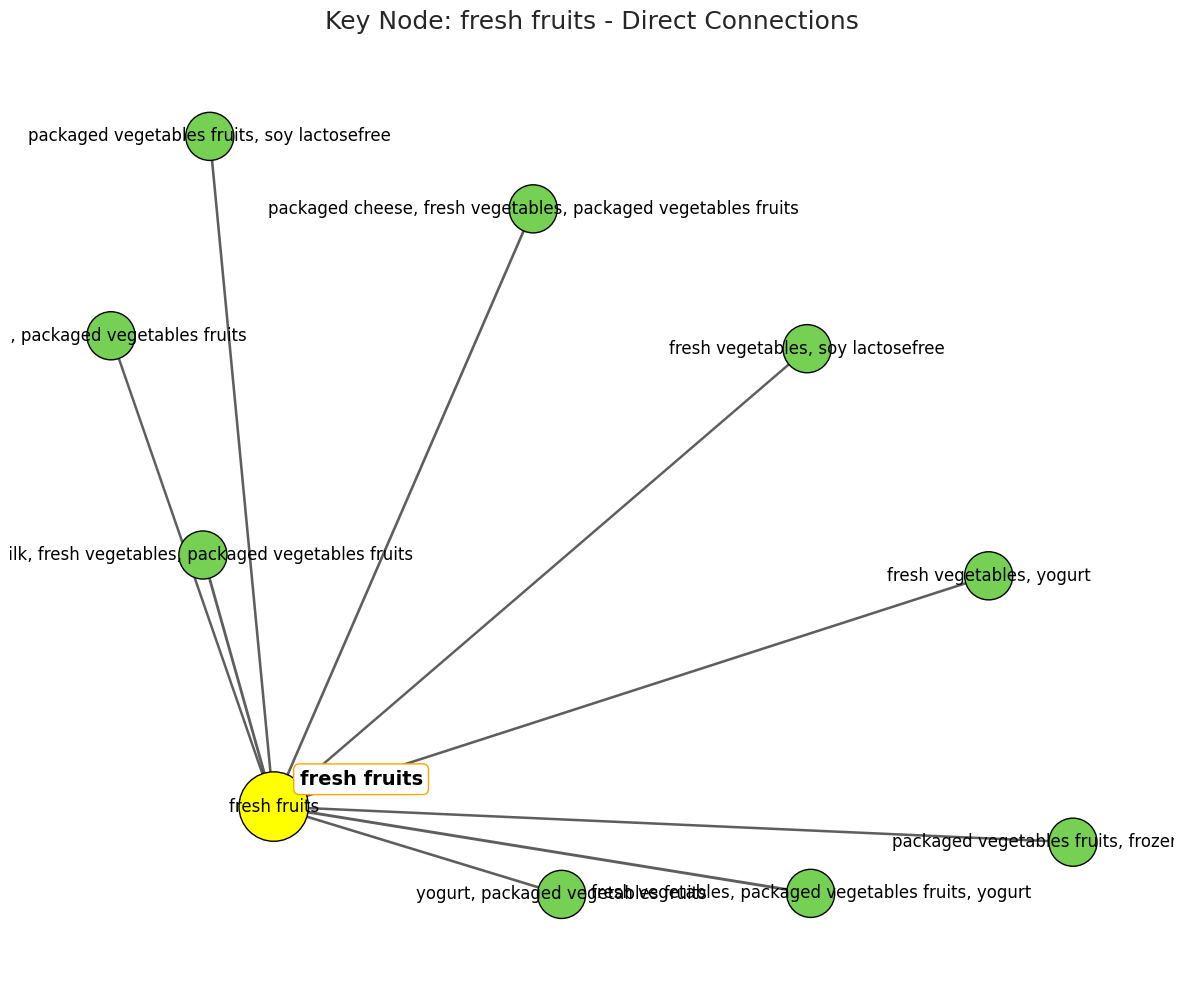

Degree Centrality for Key Nodes:
fresh vegetables, fresh fruits: 0.143
fresh vegetables: 0.476
packaged vegetables fruits: 0.548
fresh fruits: 0.214


In [48]:
# Create the truncated viridis colormap (excluding the darker end)
viridis = plt.cm.get_cmap('viridis')
trunc_viridis = color.LinearSegmentedColormap.from_list("trunc_viridis", viridis(np.linspace(0.3, 1.0, 256)))
non_key_color = trunc_viridis(0.7)

df_rules = pd.DataFrame(filtered_rules, columns=["antecedents", "consequents", "lift", "support", "confidence"])
df_rules['antecedents'] = df_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
df_rules['consequents'] = df_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph with attributes
for _, row in df_rules.iterrows():
    G.add_edge(
        row['antecedents'], 
        row['consequents'], 
        weight=row['lift'] * row['confidence'],  
        support=row['support']
    )

# Identify key nodes based on degree centrality
degree_centrality = nx.degree_centrality(G)
key_nodes = {node for node, centrality in degree_centrality.items() if centrality > 0.1}  

# Create a subgraph for each key node and plot its direct connections
for key_node in key_nodes:
    # Get the direct neighbors 
    neighbors = list(G.predecessors(key_node)) + list(G.successors(key_node))
    subgraph = G.subgraph([key_node] + neighbors)
    
    # Use a spring layout with increased spacing
    pos = nx.spring_layout(subgraph, k=1.5, seed=42)
    
    # Assign colors with key nodes in yellow
    node_sizes = [2500 if node == key_node else 1200 for node in subgraph.nodes()]
    node_colors = ['yellow' if node == key_node else non_key_color for node in subgraph.nodes()]
    
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    nx.draw_networkx_labels(subgraph, pos, font_size=12, font_color='black')
    
    # Draw edges with thinner lines
    edges = subgraph.edges(data=True)
    edge_widths = [max(0.3, data['weight'] * 1.5) for _, _, data in edges]
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, width=edge_widths, arrowstyle='->', arrowsize=10, alpha=0.7)
    
    # Add callout box for the key node
    x, y = pos[key_node]
    plt.text(x + 0.05, y + 0.05, key_node, fontsize=14, fontweight='bold', color='black',
             bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.3'))
    
    plt.title(f'Key Node: {key_node} - Direct Connections', fontsize=18, pad=20)
    plt.axis('off')
    
    # Increase left margin to accommodate text annotations
    plt.subplots_adjust(left=0.3)
    plt.tight_layout()
    
    # Save as an SVG vector file 
    filename = f"key_node_{key_node.replace(' ', '_')}.svg"
    plt.savefig(filename, format="svg", bbox_inches="tight", pad_inches=0.75)
    plt.show()

print("Degree Centrality for Key Nodes:")
for node in key_nodes:
    print(f"{node}: {degree_centrality[node]:.3f}")

# Export for use in PPT
# Export network nodes
nodes_list = []
for node in G.nodes():
    nodes_list.append({
        'node': node,
        'degree_centrality': degree_centrality[node],
        'is_key_node': node in key_nodes
    })

df_nodes = pd.DataFrame(nodes_list)
df_nodes.to_csv("aisle_network_nodes.csv", index=False)


# Export network edges
edges_list = []
for source, target, data in G.edges(data=True):
    edges_list.append({
        'source': source,
        'target': target,
        'weight': data['weight'],
        'support': data['support']
    })

df_edges = pd.DataFrame(edges_list)
df_edges.to_csv("aisle_network_edges.csv", index=False)

**Aisle-Level Dynamics**

Integrated Fresh & Packaged Produce:
Packaged vegetables, fruits stands out with the highest aisle-level centrality (0.55) and a robust set of 22 strong associations.
Fresh fruits (Degree Centrality: 0.21) and Fresh vegetables (Degree Centrality: 0.48) both show strong linkages with complementary items such as packaged vegetables, dairy, and frozen products.

Opportunity:
Consider bundled offers or thematic displays that group fresh and packaged produce with related dairy and frozen items.
Optimize aisle layout to place frequently co-purchased items in closer proximity to enhance convenience and stimulate incremental sales.


In [49]:
#  group by 'order_id' within a chunk
def group_chunk(chunk):
    return chunk.groupby('order_id')['department'].apply(list)

# split data into chunks
def split_dataframe(df, num_chunks):
    chunk_size = len(df) // num_chunks
    return [df.iloc[i * chunk_size: (i + 1) * chunk_size] for i in range(num_chunks)]

# number of CPU cores
num_cores = 16

# split the data into chunks
chunks = split_dataframe(filtered_data, num_cores)

# run the groupby operation in parallel
with Pool(num_cores) as pool:
    results = pool.map(group_chunk, chunks)

# combine results from all chunks
final_result = pd.concat(results)

# convert to list of transactions for Data Mining algorithms
transactions = final_result.tolist()

In [50]:
transactions[0:1]

[['beverages', 'household', 'household']]

In [51]:
# convert transactions list to a DataFrame in a one-hot encoded format
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_array, columns=te.columns_)

# generate frequent itemsets
frequent_itemsets = fpgrowth(df, min_support=0.1, use_colnames=True)

# display frequent itemsets
print(frequent_itemsets.tail())


      support                             itemsets
106  0.112222            (canned goods, beverages)
107  0.161344  (produce, dairy eggs, canned goods)
108  0.106814      (pantry, produce, canned goods)
109  0.102424      (snacks, produce, canned goods)
110  0.102432      (produce, canned goods, frozen)


In [52]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# sort and display rules by lift
rules_sorted = rules.sort_values(by='lift', ascending=False)
filtered_rules = rules_sorted.query("confidence > 0.70")
#filtered_rules

/var/tmp/ipykernel_3315/4258847319.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


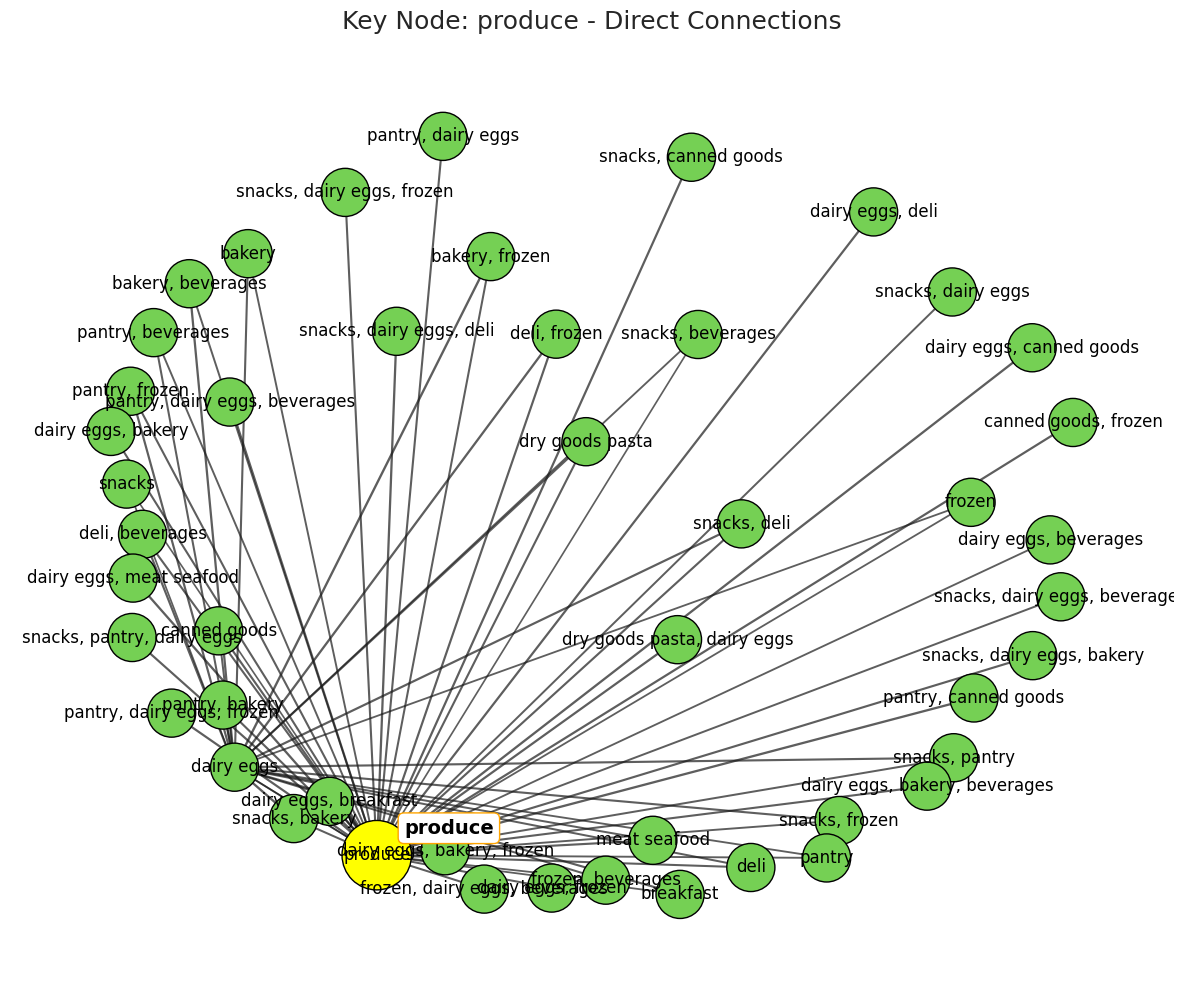

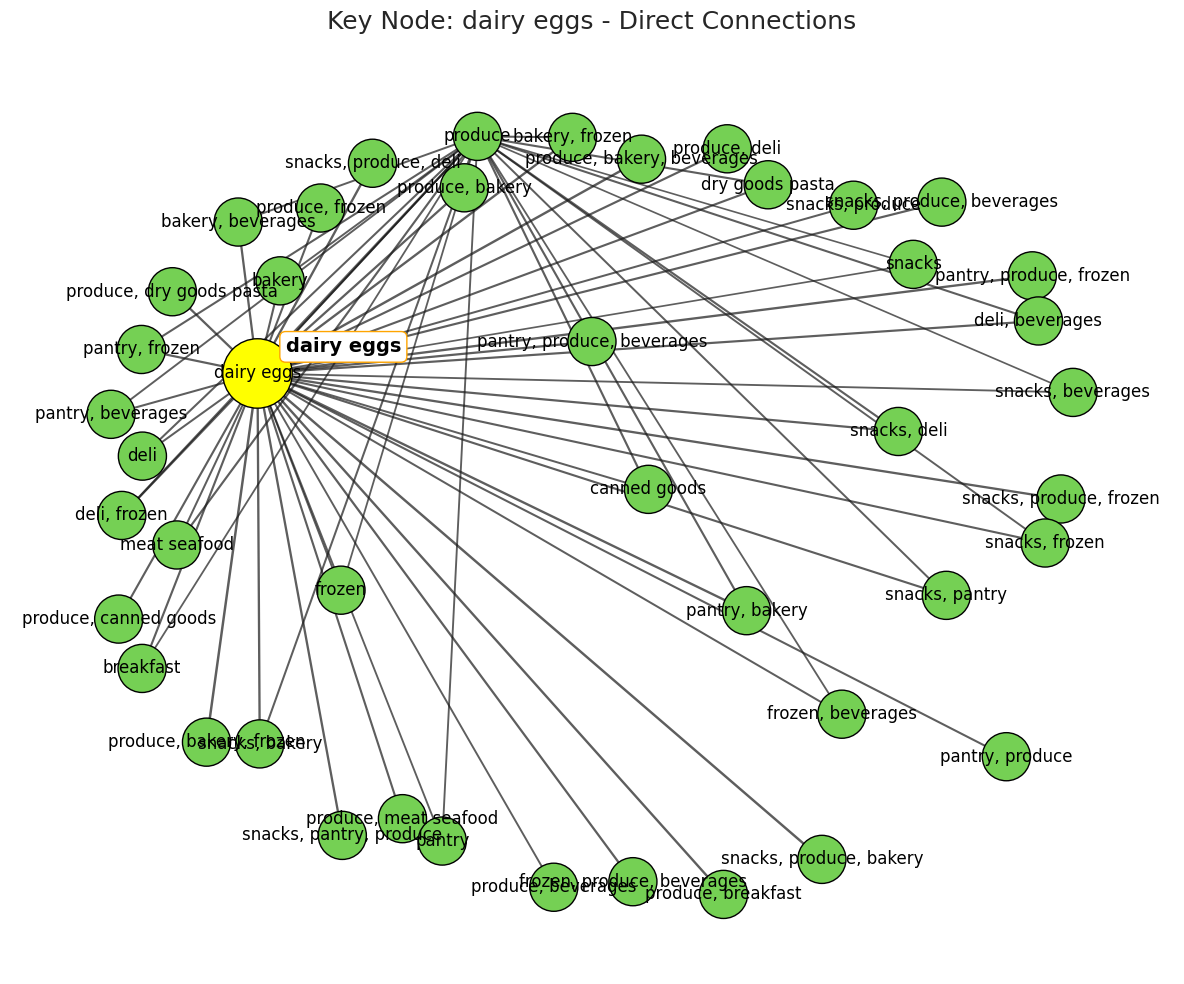

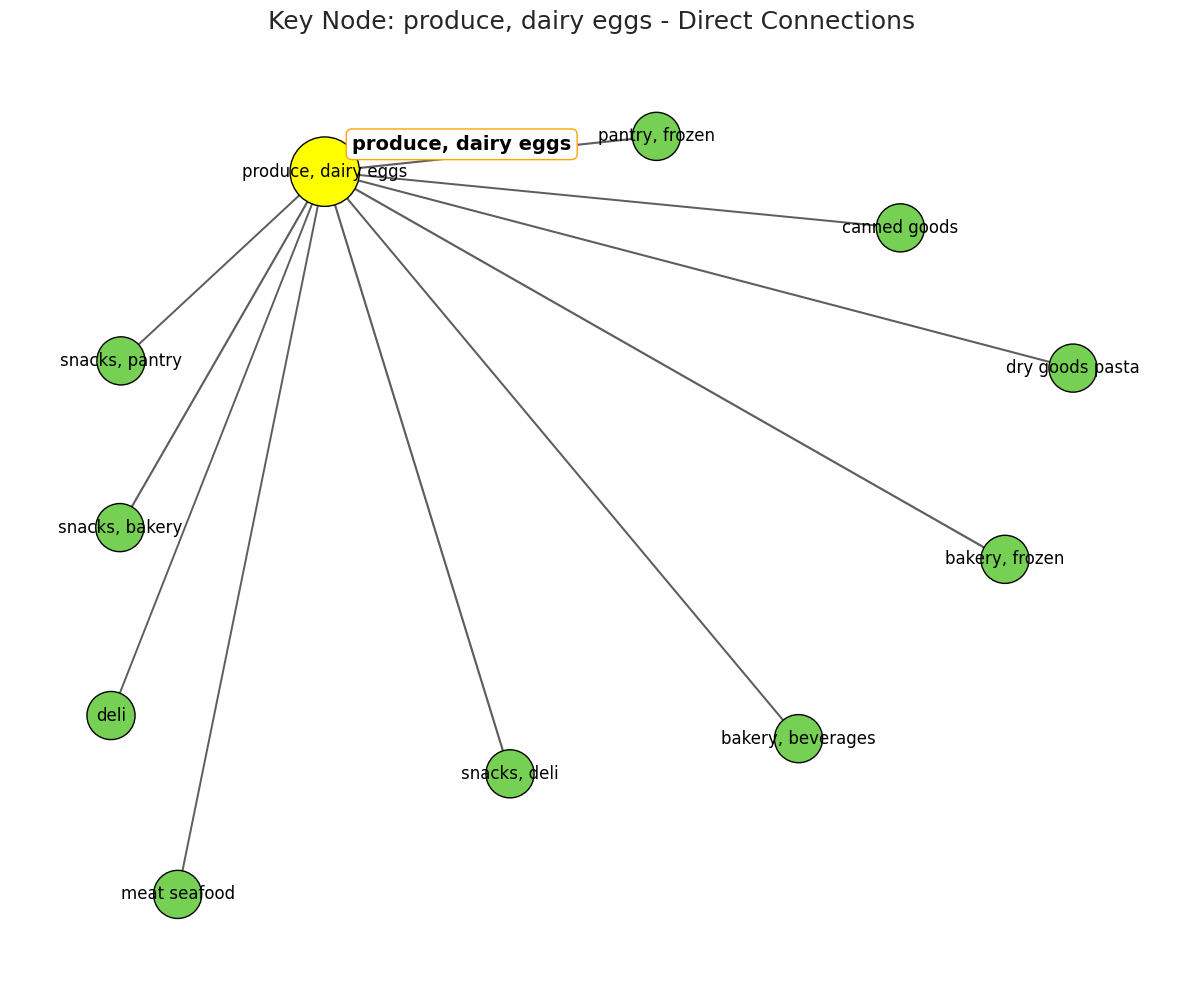

Degree Centrality for Key Nodes:
produce: 0.701
dairy eggs: 0.657
produce, dairy eggs: 0.149


In [53]:
# Create the truncated viridis colormap (excluding the darker end)
viridis = plt.cm.get_cmap('viridis')
trunc_viridis = color.LinearSegmentedColormap.from_list("trunc_viridis", viridis(np.linspace(0.3, 1.0, 256)))
non_key_color = trunc_viridis(0.7)

df_rules = pd.DataFrame(filtered_rules, columns=["antecedents", "consequents", "lift", "support", "confidence"])
df_rules['antecedents'] = df_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
df_rules['consequents'] = df_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph with attributes
for _, row in df_rules.iterrows():
    G.add_edge(
        row['antecedents'], 
        row['consequents'], 
        weight=row['lift'] * row['confidence'],  
        support=row['support']
    )

# Identify key nodes based on degree centrality
degree_centrality = nx.degree_centrality(G)
key_nodes = {node for node, centrality in degree_centrality.items() if centrality > 0.1}  

# Create a subgraph for each key node and plot its direct connections
for key_node in key_nodes:
    # Get the direct neighbors (both incoming and outgoing)
    neighbors = list(G.predecessors(key_node)) + list(G.successors(key_node))
    subgraph = G.subgraph([key_node] + neighbors)
    
    # Use a spring layout with increased spacing
    pos = nx.spring_layout(subgraph, k=1.5, seed=42)
    
    # Assign colors with key nodes in yellow
    node_sizes = [2500 if node == key_node else 1200 for node in subgraph.nodes()]
    node_colors = ['yellow' if node == key_node else non_key_color for node in subgraph.nodes()]
    
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    nx.draw_networkx_labels(subgraph, pos, font_size=12, font_color='black')
    
    # Draw edges with thinner lines
    edges = subgraph.edges(data=True)
    edge_widths = [max(0.3, data['weight'] * 1.5) for _, _, data in edges]
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, width=edge_widths, arrowstyle='->', arrowsize=10, alpha=0.7)
    
    # Add callout box for the key node
    x, y = pos[key_node]
    plt.text(x + 0.05, y + 0.05, key_node, fontsize=14, fontweight='bold', color='black',
             bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.3'))
    
    plt.title(f'Key Node: {key_node} - Direct Connections', fontsize=18, pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    # Save as an SVG vector file
    filename = f"key_node_{key_node.replace(' ', '_')}.svg"
    plt.savefig(filename, format="svg", bbox_inches="tight", pad_inches=0.75)
    plt.show()
    
print("Degree Centrality for Key Nodes:")
for node in key_nodes:
    print(f"{node}: {degree_centrality[node]:.3f}")

# Export
# Export network nodes
nodes_list = []
for node in G.nodes():
    nodes_list.append({
        'node': node,
        'degree_centrality': degree_centrality[node],
        'is_key_node': node in key_nodes
    })

df_nodes = pd.DataFrame(nodes_list)
df_nodes.to_csv("department_network_nodes.csv", index=False)


# Export network edges
edges_list = []
for source, target, data in G.edges(data=True):
    edges_list.append({
        'source': source,
        'target': target,
        'weight': data['weight'],
        'support': data['support']
    })

df_edges = pd.DataFrame(edges_list)
df_edges.to_csv("department_network_edges.csv", index=False)

**Department-Level Insights**

Produce as a Sales Engine:
The standalone Produce department exhibits the highest centrality (0.70) with 46 strong associations, underlining its role as the primary driver in shopping baskets.
Opportunity: Focus on strategic placement and marketing within the produce section to leverage its broad influence.

Dairy and Eggs – A Complementary Powerhouse:
Dairy eggs also show high centrality (0.66) and robust cross-category associations with frozen, pantry, and snacks.
Opportunity: Implement cross-promotional strategies that pair dairy and eggs with these categories, encouraging a diverse basket and enhancing customer satisfaction.

Combined Category Nuances:
The merged Produce, dairy eggs node, with a lower centrality (0.15), suggests that these departments, while important on their own, may perform better when their strategies are tailored individually rather than combined.


# Data Modeling



Our first step in data modeling is to perform customer segmentation, which helps us develop a comprehensive understanding of customer behavior across distinct groups.
To facilitate this, we create a cross-tabulation table that maps user orders to aisles. 

In [54]:
cross_df = pd.crosstab(order_products_prior.user_id, order_products_prior.aisle)
cross_df.head()

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                             0            0                 0   
2                             0            3                 0   
3                             0            0                 0   
4                             0            0                 0   
5                             0            2                 0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1                          0                  0                0   
2                          0                  0                0   
3                          0                  0                0   
4                          0                  0                0   
5                          0                  0                0   

aisle    baking ingredients  baking supplies decor  beauty  beers coolers  \
user_id                                                                     
1                         0                      0       0              0   
2                         2                      0       0              0   
3                         0                      0       0              0   
4                         0                      0       0              0   
5                         0                      0       0              0   

aisle    ...  spreads  tea  tofu meat alternatives  tortillas flat bread  \
user_id  ...                                                               
1        ...        1    0                       0                     0   
2        ...        3    1                       1                     0   
3        ...        4    1                       0                     0   
4        ...        0    0                       0                     1   
5        ...        0    0                       0                     0   

aisle    trail mix snack mix  trash bags liners  vitamins supplements  \
user_id                                                                 
1                          0                  0                     0   
2                          0                  0                     0   
3                          0                  0                     0   
4                          0                  0                     0   
5                          0                  0                     0   

aisle    water seltzer sparkling water  white wines  yogurt  
user_id                                                      
1                                    0            0       1  
2                                    2            0      42  
3                                    2            0       0  
4                                    1            0       0  
5                                    0            0       3  

[5 rows x 134 columns]

In [55]:
cross_df.tail()

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
206205                        0            0                 1   
206206                        0            4                 0   
206207                        0            0                 0   
206208                        0            3                 0   
206209                        0            1                 0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
206205                     0                  0                0   
206206                     0                  0                0   
206207                     0                  1                0   
206208                     0                  3                0   
206209                     0                  0                0   

aisle    baking ingredients  baking supplies decor  beauty  beers coolers  \
user_id                                                                     
206205                    0                      0       0              0   
206206                    4                      1       0              0   
206207                    0                      0       0              0   
206208                    4                      0       0              0   
206209                    0                      0       0              0   

aisle    ...  spreads  tea  tofu meat alternatives  tortillas flat bread  \
user_id  ...                                                               
206205   ...        0    0                       0                     0   
206206   ...        1    0                       0                     0   
206207   ...        3    4                       0                     2   
206208   ...        5    0                       0                     7   
206209   ...        0    0                       0                     0   

aisle    trail mix snack mix  trash bags liners  vitamins supplements  \
user_id                                                                 
206205                     0                  0                     0   
206206                     0                  1                     0   
206207                     1                  0                     0   
206208                     0                  0                     0   
206209                     0                  1                     0   

aisle    water seltzer sparkling water  white wines  yogurt  
user_id                                                      
206205                               0            0       5  
206206                               1            0       0  
206207                              11            0      15  
206208                               0            0      33  
206209                               0            0       3  

[5 rows x 134 columns]

In [56]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                           0.0     0.000000               0.0   
2                           0.0     0.015385               0.0   
3                           0.0     0.000000               0.0   
4                           0.0     0.000000               0.0   
5                           0.0     0.054054               0.0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1                        0.0                0.0              0.0   
2                        0.0                0.0              0.0   
3                        0.0                0.0              0.0   
4                        0.0                0.0              0.0   
5                        0.0                0.0              0.0   

aisle    baking ingredients  baking supplies decor  beauty  beers coolers  \
user_id                                                                     
1                  0.000000                    0.0     0.0            0.0   
2                  0.010256                    0.0     0.0            0.0   
3                  0.000000                    0.0     0.0            0.0   
4                  0.000000                    0.0     0.0            0.0   
5                  0.000000                    0.0     0.0            0.0   

aisle    ...   spreads       tea  tofu meat alternatives  \
user_id  ...                                               
1        ...  0.016949  0.000000                0.000000   
2        ...  0.015385  0.005128                0.005128   
3        ...  0.045455  0.011364                0.000000   
4        ...  0.000000  0.000000                0.000000   
5        ...  0.000000  0.000000                0.000000   

aisle    tortillas flat bread  trail mix snack mix  trash bags liners  \
user_id                                                                 
1                    0.000000                  0.0                0.0   
2                    0.000000                  0.0                0.0   
3                    0.000000                  0.0                0.0   
4                    0.055556                  0.0                0.0   
5                    0.000000                  0.0                0.0   

aisle    vitamins supplements  water seltzer sparkling water  white wines  \
user_id                                                                     
1                         0.0                       0.000000          0.0   
2                         0.0                       0.010256          0.0   
3                         0.0                       0.022727          0.0   
4                         0.0                       0.055556          0.0   
5                         0.0                       0.000000          0.0   

aisle      yogurt  
user_id            
1        0.016949  
2        0.215385  
3        0.000000  
4        0.000000  
5        0.081081  

[5 rows x 134 columns]

In [57]:
print(f'Number of features: {df.shape[1]}')

Number of features: 134


Our dataset is high-dimensional, containing 134 features. To enhance model performance in customer segmentation, we will reduce the number of features using Principal Componenet Analysis(PCA). PCA will retain 95% of the data's variability, ensuring minimal information loss while simplifying the feature set. 

Number of components to retain at 95% EVR: 73


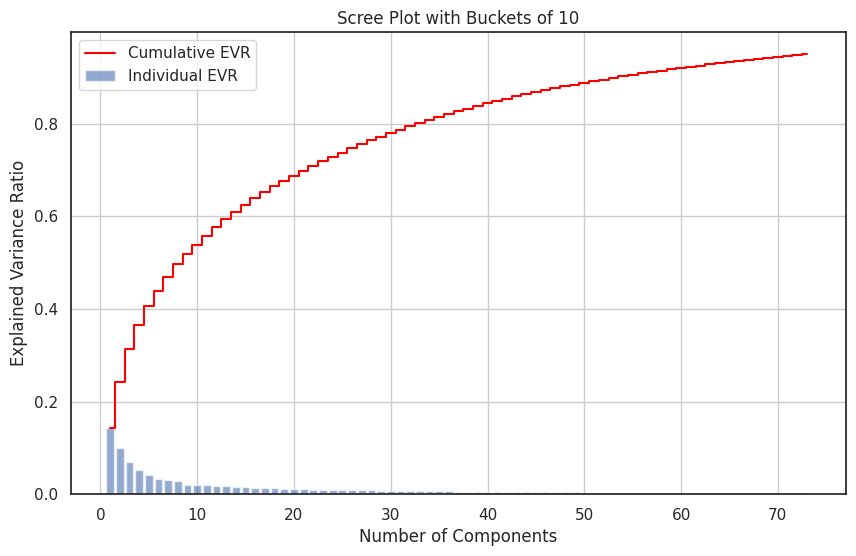

Original number of features: 134
Number of components retained: 73
Raw reduction in components: 61
Percentage reduction in components: 45.52%


In [58]:
# Apply PCA with 95% explained variance ratio (EVR)
pca = PCA(n_components=0.95)
pca.fit(df)

# Number of components
num_components = pca.n_components_
print(f"Number of components to retain at 95% EVR: {num_components}")

# Transform the data using the reduced number of components
reduced_data = pca.transform(df)

# Define variance ratios
evr = pca.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)


graph_data = pd.DataFrame({
    "Component": range(1, len(evr) + 1),
    "Individual EVR": evr,
    "Cumulative EVR": cumulative_evr
})
graph_data.to_csv("scree_plot_data.csv", index=False)

# scree plot 
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(evr) + 1), evr, alpha=0.6, label='Individual EVR', align='center')
plt.step(range(1, len(cumulative_evr) + 1), cumulative_evr, where='mid', label='Cumulative EVR', color='red')
plt.xticks(range(0, len(evr) + 1, 10))  # place into buckets of 10
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot with Buckets of 10')
plt.legend(loc='best')
plt.grid()


plt.savefig("scree_plot.svg", format="svg")
plt.show()


# Original number of features 
original_features = df.shape[1]  
retained_components = 73  # From PCA results

# Calculate raw and percentage reduction
raw_reduction = original_features - retained_components
percentage_reduction = (raw_reduction / original_features) * 100


print(f"Original number of features: {original_features}")
print(f"Number of components retained: {retained_components}")
print(f"Raw reduction in components: {raw_reduction}")
print(f"Percentage reduction in components: {percentage_reduction:.2f}%")


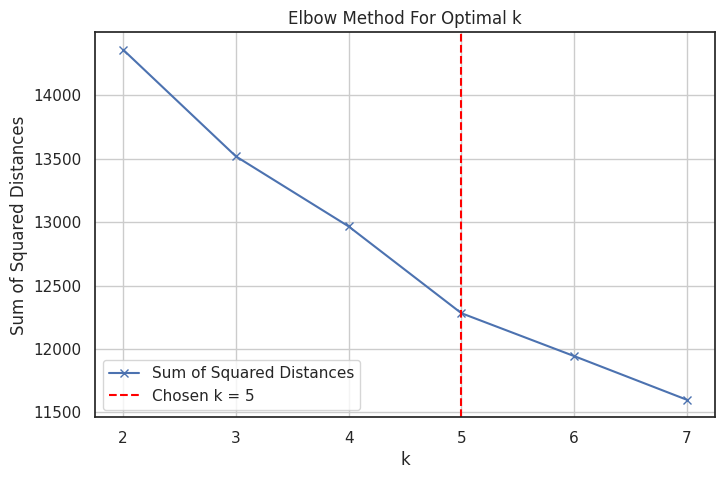

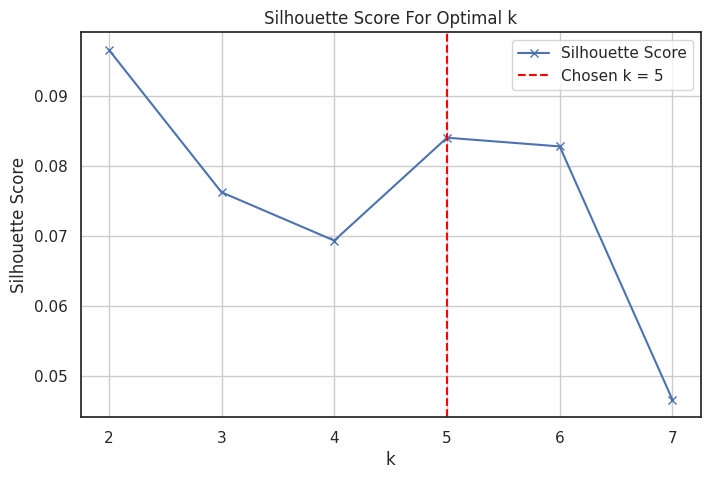

In [59]:
# compute KMeans inertia and silhouette score for a given k
def compute_kmeans_and_silhouette(k, data):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data)
    score = silhouette_score(data, km.labels_)
    return km.inertia_, score

# Range of k values
K = list(range(2, int(np.sqrt(73))))

# Parallel computation for silhouette scoring (computationally intensive)
results = Parallel(n_jobs=-1)(delayed(compute_kmeans_and_silhouette)(k, reduced_data) for k in K)

# Separate results into Sum of Squared Distances (inertia) and Silhouette Scores
Sum_of_squared_distances, silhouette_scores = zip(*results)

# Save
elbow_data = pd.DataFrame({
    "k": K,
    "Sum_of_squared_distances": Sum_of_squared_distances
})
elbow_data.to_csv("elbow_plot_data.csv", index=False)

# Save 
silhouette_data = pd.DataFrame({
    "k": K,
    "Silhouette_Score": silhouette_scores
})
silhouette_data.to_csv("silhouette_plot_data.csv", index=False)

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-', label='Sum of Squared Distances')
plt.axvline(x=5, color='red', linestyle='--', label='Chosen k = 5')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.legend()
# Save 
plt.savefig("elbow_plot.svg", format="svg")
plt.show()

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bx-', label='Silhouette Score')
plt.axvline(x=5, color='red', linestyle='--', label='Chosen k = 5')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.grid()
plt.legend()
# Save 
plt.savefig("silhouette_plot.svg", format="svg")
plt.show()


A review of the elbow method and silhouette score indicates that k=5 achieves an optimal balance between interpretability and model complexity. 

There are several inflection poins in the elbow method, where inertia drops rapidly, which might suggest increasing k. However, the silhouette score, which measures cluster cohesion and separation, revelas that fewer clusters achieve high intra-cluster similarity and inter-cluster dissimilarity. This approach ensures more precise customer segmentation. 

In [60]:
clusters = KMeans(n_clusters=5,random_state=42).fit(reduced_data)
centers = clusters.cluster_centers_
c_preds = clusters.predict(reduced_data)

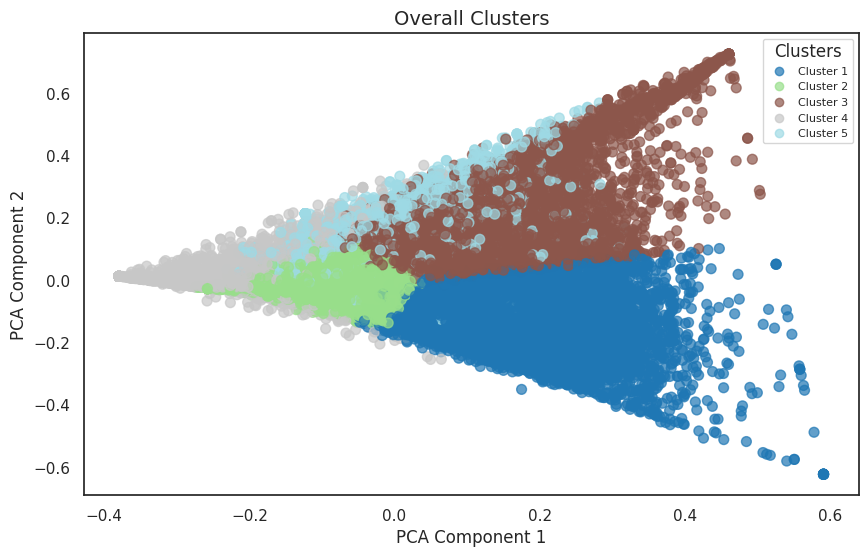

In [61]:
# define number of clusters
n_clusters = 5

# Save scatter plot data to CSV
graph_data = pd.DataFrame({
    "PCA_Component1": reduced_data[:, 0],
    "PCA_Component2": reduced_data[:, 1],
    "Cluster": c_preds
})
graph_data.to_csv("overall_clusters_data.csv", index=False)

# Create a scatter plot with unique colors for each cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=c_preds, cmap='tab20', s=50, alpha=0.7)

# Add a legend for clusters
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i + 1}" for i in range(n_clusters)], title="Clusters", loc="upper right", fontsize=8)

# Add titles and labels
plt.title("Overall Clusters", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Save as a vector image 
plt.savefig("overall_clusters.svg", format="svg")
plt.show()

# Save color mapping for use in the individual plots
cluster_colors = sns.color_palette("tab20", n_clusters)

/var/tmp/ipykernel_3315/802793108.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap("viridis")


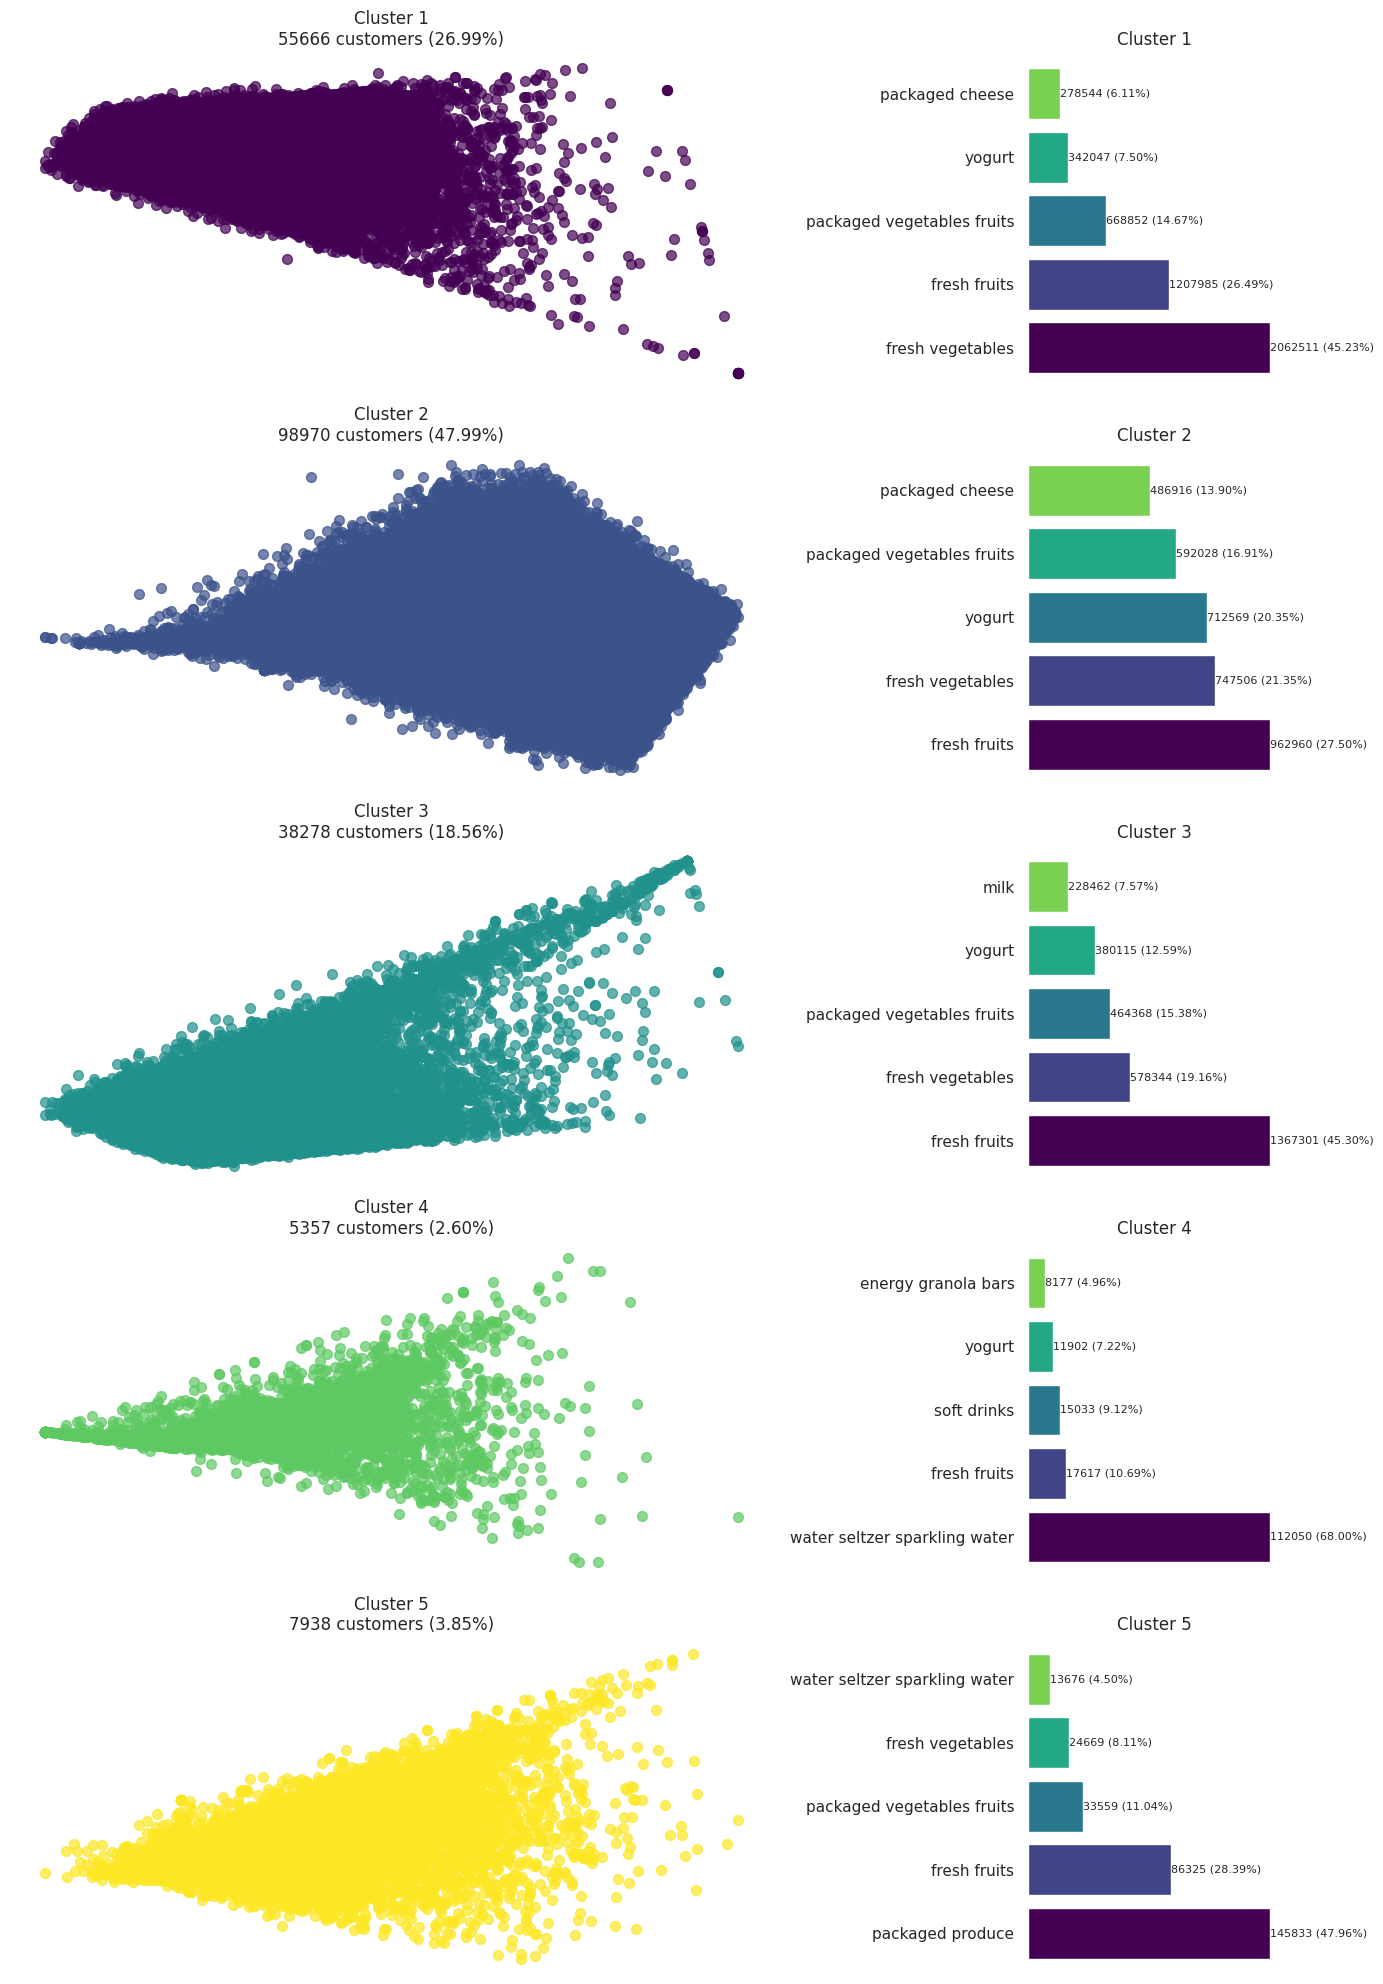

In [62]:
# Use the viridis color scale
viridis = get_cmap("viridis")
cluster_colors = viridis(np.linspace(0, 1, n_clusters))  # Generate consistent colors for each cluster

# Prepare data for individual cluster plots
cluster_sizes = np.bincount(c_preds)
cross_df["Cluster"] = c_preds  # Assign cluster labels to the original DataFrame

# Updated grid layout
num_groups = n_clusters
fig, axes = plt.subplots(num_groups, 2, figsize=(14, 4 * num_groups),
                         gridspec_kw={'width_ratios': [3, 1]})

# Iterate through each cluster
for group_idx in range(num_groups):
    scatter_ax = axes[group_idx, 0]
    bar_ax = axes[group_idx, 1]

    # Filter data for the current cluster
    cluster_id = group_idx
    cluster_data = cross_df[cross_df["Cluster"] == cluster_id].sum().drop("Cluster")
    cluster_data = cluster_data[cluster_data > 0]  # Remove aisles with zero counts

    # Get top 5 aisles
    top_5_aisles = cluster_data.sort_values(ascending=False).head(5)

    # Scatter plot for the current cluster
    mask = c_preds == cluster_id
    scatter = scatter_ax.scatter(
        reduced_data[mask, 0], reduced_data[mask, 1],
        color=[cluster_colors[cluster_id]], s=50, alpha=0.7
    )

    # Title for scatter plot
    scatter_ax.set_title(
        f"Cluster {cluster_id + 1}\n{cluster_sizes[cluster_id]} customers ({(cluster_sizes[cluster_id] / cluster_sizes.sum() * 100):.2f}%)",
        fontsize=12
    )
    scatter_ax.axis('off')

    # Bar chart for top 5 aisles
    aisles = top_5_aisles.index
    counts = top_5_aisles.values
    percentages = (counts / counts.sum()) * 100

    bars = bar_ax.barh(aisles, counts, color=[viridis(i / n_clusters) for i in range(len(aisles))])

    # Add aisle names and percentages to the end of each bar
    for bar, aisle, count, percentage in zip(bars, aisles, counts, percentages):
        bar_ax.text(
            bar.get_width() + 5, bar.get_y() + bar.get_height() / 2,
            f"{int(count)} ({percentage:.2f}%)",
            va="center", fontsize=8
        )

    # Title for bar chart
    bar_ax.set_title(f"Cluster {cluster_id + 1}", fontsize=12)

    # Remove unnecessary elements from bar chart
    bar_ax.spines['top'].set_visible(False)
    bar_ax.spines['right'].set_visible(False)
    bar_ax.spines['left'].set_visible(False)
    bar_ax.spines['bottom'].set_visible(False)
    bar_ax.tick_params(left=False, bottom=False)  # Remove ticks
    bar_ax.set_xticks([])  # Remove x-axis scale

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


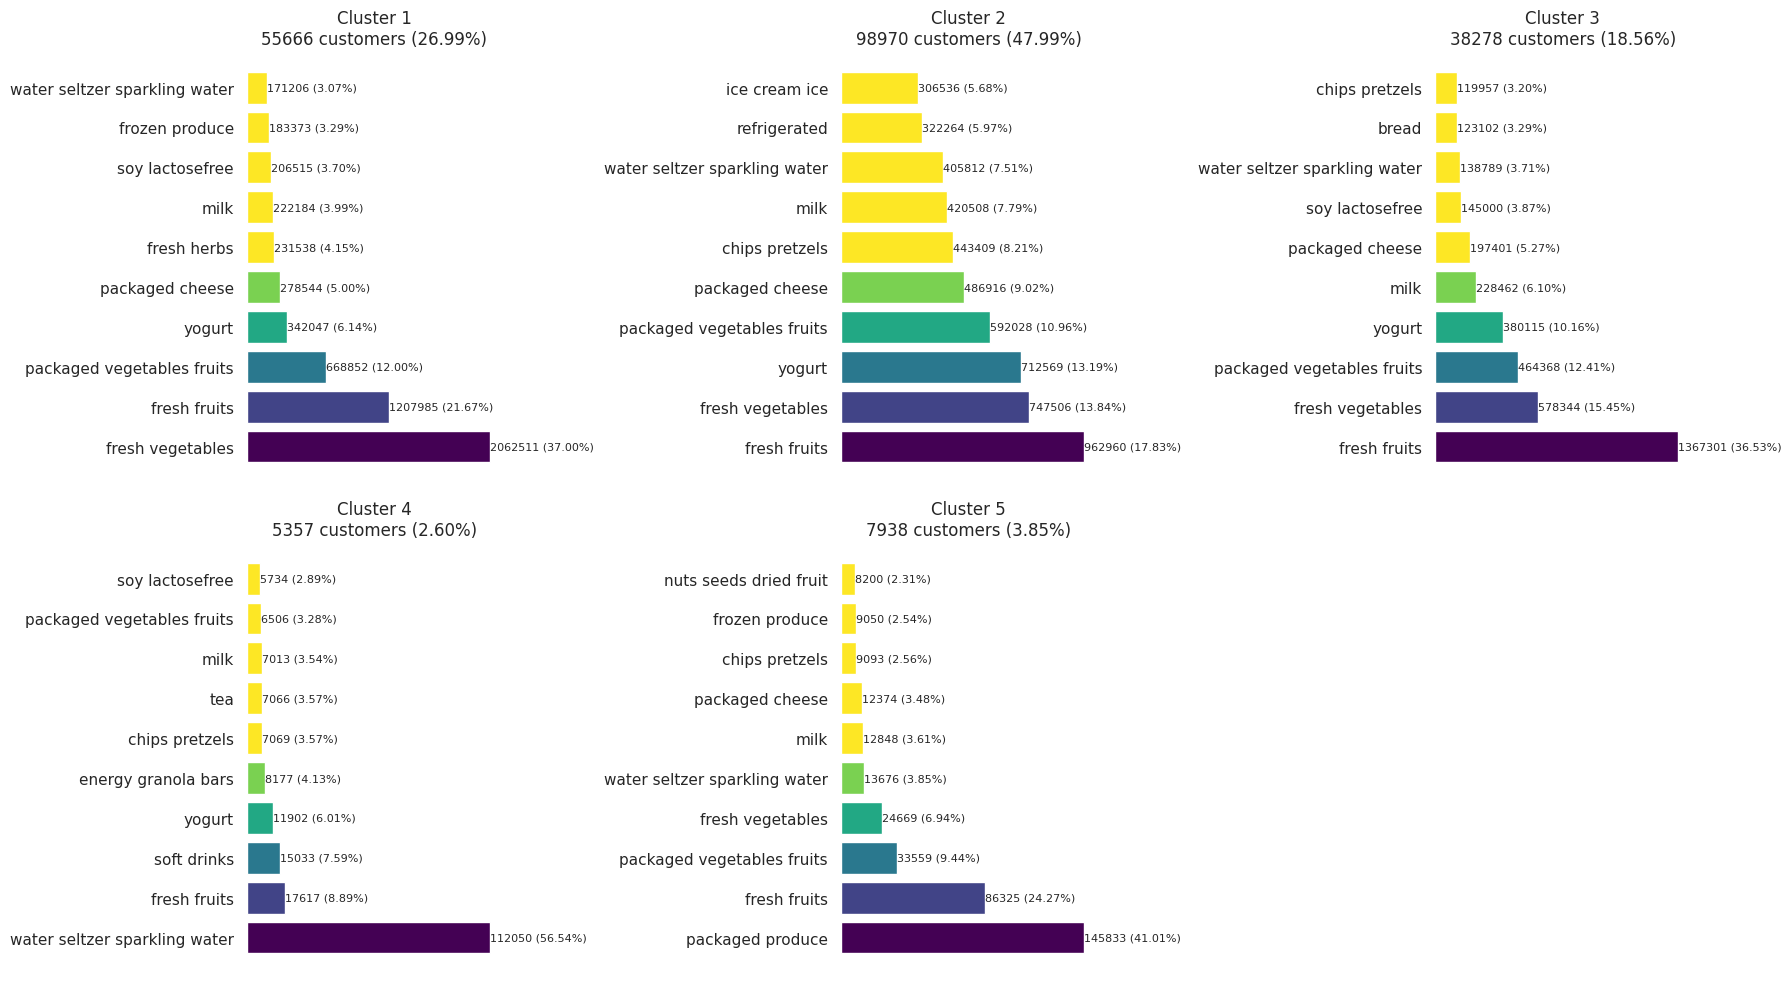

In [63]:
# Prepare layout for 5 clusters (3 in the first row, 2 in the second row)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Iterate through each cluster
for cluster_id in range(n_clusters):
    bar_ax = axes[cluster_id]  # Select appropriate axis

    # Filter data for the current cluster
    cluster_data = cross_df[cross_df["Cluster"] == cluster_id].sum().drop("Cluster")
    cluster_data = cluster_data[cluster_data > 0]  # Remove aisles with zero counts

    # Get top 10 aisles
    top_10_aisles = cluster_data.sort_values(ascending=False).head(10)

    # Save top 10 aisles to CSV
    top_10_df = top_10_aisles.reset_index()
    top_10_df.columns = ['Aisle', 'Count']
    top_10_df['Percentage'] = (top_10_df['Count'] / top_10_df['Count'].sum()) * 100
    top_10_df.to_csv(f"cluster_{cluster_id+1}_top10.csv", index=False)


    # Bar chart for top 10 aisles
    aisles = top_10_aisles.index
    counts = top_10_aisles.values
    percentages = (counts / counts.sum()) * 100

    bars = bar_ax.barh(aisles, counts, color=[viridis(i / n_clusters) for i in range(len(aisles))])

    # Add aisle names and percentages to the end of each bar
    for bar, aisle, count, percentage in zip(bars, aisles, counts, percentages):
        bar_ax.text(
            bar.get_width() + 5, bar.get_y() + bar.get_height() / 2,
            f"{int(count)} ({percentage:.2f}%)",
            va="center", fontsize=8
        )

    # Title for the bar chart
    bar_ax.set_title(f"Cluster {cluster_id + 1}\n{cluster_sizes[cluster_id]} customers ({(cluster_sizes[cluster_id] / cluster_sizes.sum() * 100):.2f}%)", fontsize=12)

    # Remove unnecessary elements from the chart
    bar_ax.spines['top'].set_visible(False)
    bar_ax.spines['right'].set_visible(False)
    bar_ax.spines['left'].set_visible(False)
    bar_ax.spines['bottom'].set_visible(False)
    bar_ax.tick_params(left=False, bottom=False)  # Remove ticks
    bar_ax.set_xticks([])  # Remove x-axis scale

# Remove empty subplot (6th position, as we have only 5 clusters)
fig.delaxes(axes[-1])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


**Customer Segmentation Insights**

Fresh Produce Anchors Loyalty: Fresh fruits and vegetables are consistently top-ranked across all clusters, making them a strategic cornerstone for retention and recommendation systems.

Cluster 1 (27%) – Health-Conscious StaplesPrioritizes fresh produce, yogurt, soy/lactose-free items, and packaged vegetables. Indicates a wellness-driven, ingredient-aware customer base receptive to clean-label and organic promotions.

Cluster 2 (48%) – Balanced and IndulgentLargest segment with both core staples (milk, yogurt, fresh produce) and indulgent/snack items (ice cream, chips). Ideal for broad campaigns that combine health and treat-based messaging.

Cluster 3 (19%) – Core StaplesLeans on bread, milk, cheese, yogurt, and fresh produce. Represents a conventional, family-focused basket—well suited for promotions around household staples and weekly meal planning.

Cluster 4 (2.6%) – Beverage-Centric NicheDominated by sparkling water, with moderate interest in tea, soft drinks, and snacks. Indicates a small but highly focused group ideal for beverage brand partnerships and loyalty bundles.

Cluster 5 (3.9%) – Packaged Convenience ShoppersStrong preference for packaged produce, fresh fruits, and nuts/dried fruit. Suggests grab-and-go and snack pack appeal—ideal for ready-to-eat promotions and time-saving meal solutions.

Cross-Selling Opportunity: Frequent co-purchases in dairy, produce, and snacks highlight opportunities for targeted bundles (e.g., yogurt + fresh fruit, milk + cereal alternatives).

Strategic Takeaway: Use fresh produce as a universal hook across segments, while tailoring upsells and messaging based on segment-specific priorities—e.g., indulgence, convenience, or wellness.


In [64]:
# Prepare a list to collect graph data for each cluster
all_clusters_data = []

# Loop through each cluster
for cluster_id in range(n_clusters):
    # Filter data for the current cluster
    cluster_data = cross_df[cross_df["Cluster"] == cluster_id].sum().drop("Cluster")
    # Remove aisles with zero counts
    cluster_data = cluster_data[cluster_data > 0]
    
    # Get top 10 aisles by count
    top_10_aisles = cluster_data.sort_values(ascending=False).head(10)
    
    # Extract aisle names, counts, and compute percentages
    aisles = top_10_aisles.index.tolist()
    counts = top_10_aisles.values
    percentages = (counts / counts.sum()) * 100
    
    # Create a DataFrame for the current cluster's bar graph data
    cluster_df = pd.DataFrame({
        "Cluster": [cluster_id + 1] * len(aisles),
        "Aisle": aisles,
        "Count": counts,
        "Percentage": percentages
    })
    all_clusters_data.append(cluster_df)
    
    # Create a new figure for the bar graph
    plt.figure(figsize=(8, 6))
    bars = plt.barh(aisles, counts, color=[viridis(i / n_clusters) for i in range(len(aisles))])
    
    # Add text labels at the end of each bar
    for bar, count, percentage in zip(bars, counts, percentages):
        plt.text(
            bar.get_width() + 5, 
            bar.get_y() + bar.get_height() / 2,
            f"{int(count)} ({percentage:.2f}%)",
            va="center", fontsize=8
        )
    
    # Title with cluster size info
    cluster_title = (
        f"Cluster {cluster_id + 1}\n"
        f"{cluster_sizes[cluster_id]} customers "
        f"({(cluster_sizes[cluster_id] / cluster_sizes.sum() * 100):.2f}%)"
    )
    plt.title(cluster_title, fontsize=12)
    
    # Remove unnecessary spines and ticks
    ax = plt.gca()
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.set_xticks([])
    
    # Adjust layout and save the figure as an SVG vector image
    plt.tight_layout()
    svg_filename = f"cluster_{cluster_id + 1}_bar_chart.svg"
    plt.savefig(svg_filename, format="svg")
    plt.close()  # Close the figure after saving

# Combine all cluster output data into a single DataFrame and save to CSV
all_data_df = pd.concat(all_clusters_data, ignore_index=True)
all_data_df.to_csv("clusters_bar_graph_data.csv", index=False)


# Modeling

In [65]:
train.head()

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         1       49302                  1          1   112108    train   
1         1       11109                  2          1   112108    train   
2         1       10246                  3          0   112108    train   
3         1       49683                  4          0   112108    train   
4         1       43633                  5          1   112108    train   

   order_number  order_dow order_hour_of_day  days_since_prior_order  \
0             4  Wednesday           10:00AM                     9.0   
1             4  Wednesday           10:00AM                     9.0   
2             4  Wednesday           10:00AM                     9.0   
3             4  Wednesday           10:00AM                     9.0   
4             4  Wednesday           10:00AM                     9.0   

                                    product_name  aisle_id  department_id  \
0                               Bulgarian Yogurt       120             16   
1  Organic 4% Milk Fat Whole Milk Cottage Cheese       108             16   
2                          Organic Celery Hearts        83              4   
3                                 Cucumber Kirby        83              4   
4           Lightly Smoked Sardines in Olive Oil        95             15   

                  aisle    department  
0                yogurt    dairy eggs  
1  other creams cheeses    dairy eggs  
2      fresh vegetables       produce  
3      fresh vegetables       produce  
4   canned meat seafood  canned goods

In [66]:
test.head()

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
4         2       30035                  5          0   202279    prior   

   order_number order_dow order_hour_of_day  days_since_prior_order  \
0             3  Thursday            9:00AM                     8.0   
1             3  Thursday            9:00AM                     8.0   
2             3  Thursday            9:00AM                     8.0   
3             3  Thursday            9:00AM                     8.0   
4             3  Thursday            9:00AM                     8.0   

            product_name  aisle_id  department_id               aisle  \
0     Organic Egg Whites        86             16                eggs   
1  Michigan Organic Kale        83              4    fresh vegetables   
2          Garlic Powder       104             13   spices seasonings   
3         Coconut Butter        19             13       oils vinegars   
4      Natural Sweetener        17             13  baking ingredients   

   department  
0  dairy eggs  
1     produce  
2      pantry  
3      pantry  
4      pantry

In [67]:
test.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [68]:
# Remove test rows where order_number equals 1, since first orders cannot have reorders.
test = test[test['order_number'] != 1]

### Feature Engineering

The analysis of association rules and frequent itemsets revealed notable trends at the product, aisle, and department levels. Our dataset,however, contains too many individual products to allow for new product-specific features. Instead, we focus on engineering new features at the the aisle and department levels. In the following code, we introduce variables representing the percentage of purchases within various categories. Given our earlier observations of strong associations involving organic products, we also include a feature for the proportion of organic purchases. These refined features, taken together, are expected to ehnance model performance. 

In [69]:
# Compute Aggregates on Training Data

# Aisle percentages per user 
aisle_percentages_train = (
    round(train.groupby('user_id')['aisle_id'].value_counts(normalize=True), 2)
    .reset_index(name='aisle_perc')
)

# Department percentages per user 
department_percentages_train = (
    round(train.groupby('user_id')['department_id'].value_counts(normalize=True), 2)
    .reset_index(name='dept_perc')
)

# Create a flag for Organic products and compute percentage per user
train['is_organic'] = train['product_name'].str.contains('Organic', case=False, na=False)
organic_percentages_train = (
    train.groupby('user_id')['is_organic']
    .mean()
    .round(2)
    .reset_index(name='organic_perc')
)

# Merge aggregated features into the training data
train = train.merge(aisle_percentages_train, on=['user_id', 'aisle_id'], how='left')
train = train.merge(department_percentages_train, on=['user_id', 'department_id'], how='left')
train = train.merge(organic_percentages_train, on='user_id', how='left')


# Apply Aggregates to Test Data and Impute Missing Values

# Merge aggregated features from training into the test data
test = test.merge(aisle_percentages_train, on=['user_id', 'aisle_id'], how='left')
test = test.merge(department_percentages_train, on=['user_id', 'department_id'], how='left')

# Compute the organic flag in test data and merge the training-based organic percentage
test['is_organic'] = test['product_name'].str.contains('Organic', case=False, na=False)
test = test.merge(organic_percentages_train, on='user_id', how='left')


# Impute Missing Values in Test Data with Median from Training

default_aisle = train['aisle_perc'].median()
default_dept = train['dept_perc'].median()
default_organic = train['organic_perc'].median()

test['aisle_perc'].fillna(default_aisle, inplace=True)
test['dept_perc'].fillna(default_dept, inplace=True)
test['organic_perc'].fillna(default_organic, inplace=True)


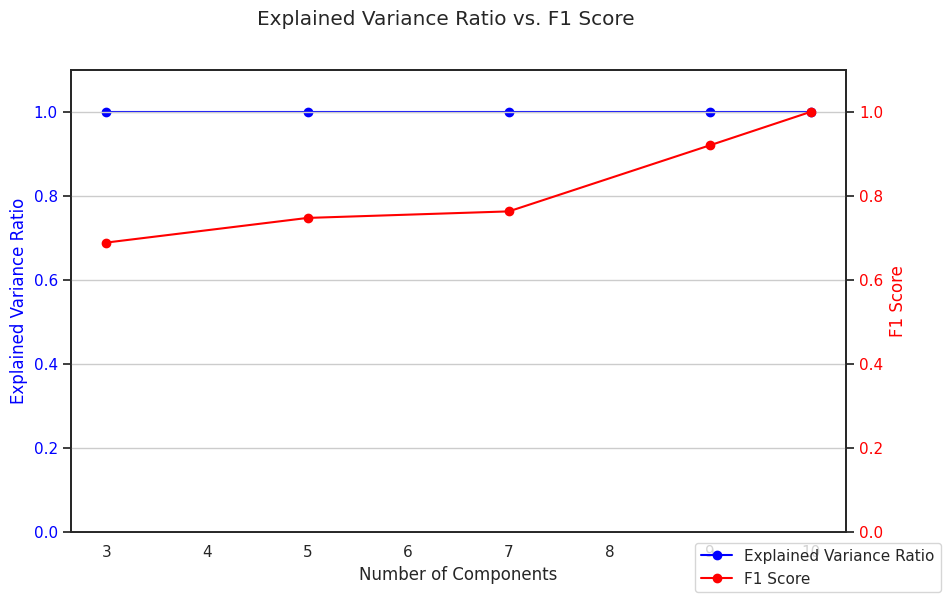

In [70]:
# Identify categorical and numeric columns 
categorical_cols = train.select_dtypes(include=["object", "category"]).columns
numeric_cols = train.select_dtypes(include=["number"]).columns

# One-hot encode categorical columns for both datasets
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
encoded_train = enc.fit_transform(train[categorical_cols])
encoded_test = enc.transform(test[categorical_cols])

# Convert numeric columns to sparse matrices
numeric_train = csr_matrix(train[numeric_cols].values)
numeric_test = csr_matrix(test[numeric_cols].values)

# Combine numeric and encoded categorical data
combined_train_sparse = hstack([numeric_train, encoded_train])
combined_test_sparse = hstack([numeric_test, encoded_test])


# Evaluate Explained Variance Ratio and Model Performance

components_to_test = [3, 5, 7, 9, 10]
evr_list = []
f1_scores = []

for n_components in components_to_test:
    # Apply Truncated SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_train = svd.fit_transform(combined_train_sparse)
    reduced_test = svd.transform(combined_test_sparse)
    
    # Compute total explained variance ratio
    evr = svd.explained_variance_ratio_.sum()
    evr_list.append(evr)
    
    # Train Random Forest on training data
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    clf.fit(reduced_train, train["reordered"])
    
    # Evaluate performance on test data
    y_pred = clf.predict(reduced_test)
    f1 = f1_score(test["reordered"], y_pred)
    f1_scores.append(f1)


# Plot Explained Variance Ratio vs. F1 Score

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Explained Variance Ratio (blue)
ax1.plot(components_to_test, evr_list, color="blue", marker="o", label="Explained Variance Ratio")
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Explained Variance Ratio", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(0, 1.1)

# Plot F1 Score (red)
ax2 = ax1.twinx()
ax2.plot(components_to_test, f1_scores, color="red", marker="o", label="F1 Score")
ax2.set_ylabel("F1 Score", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 1.1)

fig.suptitle("Explained Variance Ratio vs. F1 Score")
fig.legend(loc="lower right")
plt.grid()
plt.show()

### Explanation

Initially, I chose 3 components because it maximized the Explained Variance Ratio (EVR), capturing 100% of the variance in the data. However, the model's performance, measured by F1 score, was poor with only 3 components. This highlighted the need to reassess my approach.

EVR measures how much variance in the dataset is retained by the components, but it does not indicate how well these components relate to the target variable. High EVR with few components often captures dominant patterns that may not be predictive of the target.

By increasing the number of components, I allowed the model to retain additional patterns—less dominant but more predictive—resulting in improved F1 scores. This demonstrates that optimizing for EVR alone is insufficient; model performance must guide the choice of components.


### Usage of Truncated SVD

I initially attempted to use PCA for dimensionality reduction, but it caused memory requirements to exceed 400GB. This is because PCA produces a dense, sparse one-hot encoded dataset, making it infeasible for a large market basket analysis dataset.

To address this, I used Truncated SVD, which is designed for sparse matrices. Unlike PCA, Truncated SVD works directly on the sparse representation without converting it to dense format, drastically reducing memory usage. This allowed me to effectively reduce dimensionality while retaining the critical variance needed for modeling.


Random Forest is the first ML model that will be applied to the dataset. For model performance, we will compare the performance of SMOTE and SMOTEEN models. SMOTE is an oversampling technique that increases instances of the minority class, on the other hand, SMOTENN is an undersampling technique to remove ambiguous decision points along the decision boundary. 

### Random Forest Base Model

In [71]:
optimal_n_components = 7
svd = TruncatedSVD(n_components=optimal_n_components, random_state=42)
X_train_pca = svd.fit_transform(combined_train_sparse)
X_test_pca = svd.transform(combined_test_sparse)

y_train = train["reordered"]
y_test = test["reordered"]

classification_report_results = {}
confusion_matrix_results = {}

param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

def build_and_evaluate_classifier(X_tr, y_tr, X_ts, y_ts, label="RF - Base"):
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        verbose=0,
        n_iter=5
    )
    random_search.fit(X_tr, y_tr)
    
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_ts)
    test_f1 = f1_score(y_ts, y_pred)
    
    cm = confusion_matrix(y_ts, y_pred)
    confusion_matrix_results[label] = list(cm.ravel()) 
    
    report_dict = classification_report(
        y_ts,
        y_pred,
        target_names=["Not Reordered", "Reordered"],
        output_dict=True
    )
    classification_report_results[label] = {
        "Not Reordered Precision": round(report_dict["Not Reordered"]["precision"], 2),
        "Not Reordered Recall": round(report_dict["Not Reordered"]["recall"], 2),
        "Not Reordered F1-Score": round(report_dict["Not Reordered"]["f1-score"], 2),
        "Reordered Precision": round(report_dict["Reordered"]["precision"], 2),
        "Reordered Recall": round(report_dict["Reordered"]["recall"], 2),
        "Reordered F1-Score": round(report_dict["Reordered"]["f1-score"], 2)
    }
    
    return best_params, test_f1, classification_report_results[label], confusion_matrix_results[label]

print(" Baseline (No Resampling) ")
baseline_params, baseline_f1, baseline_report, baseline_cm = build_and_evaluate_classifier(
    X_train_pca, y_train, X_test_pca, y_test, label="RF - Base"
)
print(f"Best Parameters: {baseline_params}")
print(f"Test F1 Score: {baseline_f1:.4f}")
print("Classification Report:")
print(baseline_report)
print("Confusion Matrix (TN, FP, FN, TP):")
print(baseline_cm)

print("Stored Classification Report Keys:", list(classification_report_results.keys()))
print("Stored Confusion Matrix Keys:", list(confusion_matrix_results.keys()))


 Baseline (No Resampling) 
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5}
Test F1 Score: 0.7754
Classification Report:
{'Not Reordered Precision': 0.62, 'Not Reordered Recall': 0.34, 'Not Reordered F1-Score': 0.44, 'Reordered Precision': 0.69, 'Reordered Recall': 0.88, 'Reordered F1-Score': 0.78}
Confusion Matrix (TN, FP, FN, TP):
[3764229, 7465656, 2287152, 16839384]
Stored Classification Report Keys: ['RF - Base']
Stored Confusion Matrix Keys: ['RF - Base']


### Random Forest with Sampling Techniques

In [72]:
# SMOTE Resampling
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train_pca, y_train)

print("\n SMOTE Resampling")
print(f"Class distribution before SMOTE: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTE:  0 -> {sum(y_train_res_smote==0)}, 1 -> {sum(y_train_res_smote==1)}")

smote_params, smote_f1, smote_report, smote_cm = build_and_evaluate_classifier(
    X_train_res_smote, y_train_res_smote, X_test_pca, y_test, label="RF - SMOTE"
)
print(f"Best Parameters: {smote_params}")
print(f"Test F1 Score: {smote_f1:.4f}")
print("Classification Report (RF SMOTE):")
print(smote_report)
print("Confusion Matrix (RF SMOTE) (TN, FP, FN, TP):")
print(smote_cm)

# SMOTEENN Resampling
smote_enn = SMOTEENN(random_state=42)
X_train_res_smoteenn, y_train_res_smoteenn = smote_enn.fit_resample(X_train_pca, y_train)

print("\n SMOTEENN Resampling ")
print(f"Class distribution before SMOTEENN: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTEENN:  0 -> {sum(y_train_res_smoteenn==0)}, 1 -> {sum(y_train_res_smoteenn==1)}")

smoteenn_params, smoteenn_f1, smoteenn_report, smoteenn_cm = build_and_evaluate_classifier(
    X_train_res_smoteenn, y_train_res_smoteenn, X_test_pca, y_test, label="RF - SMOTEENN"
)
print(f"Best Parameters: {smoteenn_params}")
print(f"Test F1 Score: {smoteenn_f1:.4f}")
print("Classification Report (RF SMOTEENN):")
print(smoteenn_report)
print("Confusion Matrix (RF SMOTEENN) (TN, FP, FN, TP):")
print(smoteenn_cm)

# Summary of Results
print("\n Summary of F1 Scores ")
print(f"RF Baseline (No Resampling): {baseline_f1:.4f}")
print(f"RF SMOTE:                   {smote_f1:.4f}")
print(f"RF SMOTEENN:               {smoteenn_f1:.4f}")



 SMOTE Resampling
Class distribution before SMOTE: 0 -> 555793, 1 -> 828824
Class distribution after SMOTE:  0 -> 828824, 1 -> 828824
Best Parameters: {'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}
Test F1 Score: 0.7075
Classification Report (RF SMOTE):
{'Not Reordered Precision': 0.52, 'Not Reordered Recall': 0.61, 'Not Reordered F1-Score': 0.56, 'Reordered Precision': 0.75, 'Reordered Recall': 0.67, 'Reordered F1-Score': 0.71}
Confusion Matrix (RF SMOTE) (TN, FP, FN, TP):
[6894923, 4334962, 6285168, 12841368]

 SMOTEENN Resampling 
Class distribution before SMOTEENN: 0 -> 555793, 1 -> 828824
Class distribution after SMOTEENN:  0 -> 282868, 1 -> 232746
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
Test F1 Score: 0.6527
Classification Report (RF SMOTEENN):
{'Not Reordered Precision': 0.49, 'Not Reordered Recall': 0.7, 'Not Reordered F1-Score': 0.5

### AdaBoost Base Model

In [73]:
# Parameter Grid
param_dist = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1, 1],
}

def build_and_evaluate_classifier(X_tr, y_tr, X_ts, y_ts, label="AdaBoost - Base"):
    clf = AdaBoostClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        verbose=0,
        n_iter=5
    )
    random_search.fit(X_tr, y_tr)
    
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_ts)
    test_f1 = f1_score(y_ts, y_pred)
    
    cm = confusion_matrix(y_ts, y_pred)
    confusion_matrix_results[label] = list(cm.ravel())
    
    report_dict = classification_report(
        y_ts, 
        y_pred, 
        target_names=["Not Reordered", "Reordered"],
        output_dict=True
    )
    classification_report_results[label] = {
        "Not Reordered Precision": round(report_dict["Not Reordered"]["precision"], 2),
        "Not Reordered Recall": round(report_dict["Not Reordered"]["recall"], 2),
        "Not Reordered F1-Score": round(report_dict["Not Reordered"]["f1-score"], 2),
        "Reordered Precision": round(report_dict["Reordered"]["precision"], 2),
        "Reordered Recall": round(report_dict["Reordered"]["recall"], 2),
        "Reordered F1-Score": round(report_dict["Reordered"]["f1-score"], 2)
    }
    
    return best_params, test_f1, classification_report_results[label], confusion_matrix_results[label]

print("Baseline (No Resampling) - AdaBoost")
baseline_params, baseline_f1, baseline_report, baseline_cm = build_and_evaluate_classifier(
    X_train_pca, y_train, X_test_pca, y_test, label="AdaBoost - Base"
)
print(f"Best Parameters: {baseline_params}")
print(f"Test F1 Score: {baseline_f1:.4f}")
print("Classification Report:")
print(baseline_report)
print("Confusion Matrix (TN, FP, FN, TP):")
print(baseline_cm)


Baseline (No Resampling) - AdaBoost


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Best Parameters: {'n_estimators': 100, 'learning_rate': 0.01}
Test F1 Score: 0.7794
Classification Report:
{'Not Reordered Precision': 0.66, 'Not Reordered Recall': 0.2, 'Not Reordered F1-Score': 0.3, 'Reordered Precision': 0.67, 'Reordered Recall': 0.94, 'Reordered F1-Score': 0.78}
Confusion Matrix (TN, FP, FN, TP):
[2207630, 9022255, 1153236, 17973300]


### AdaBoost with Sampling Techniques

In [74]:
# SMOTE Resampling 
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train_pca, y_train)

print("\n AdaBoost SMOTE Resampling")
print(f"Class distribution before SMOTE: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTE:  0 -> {sum(y_train_res_smote==0)}, 1 -> {sum(y_train_res_smote==1)}")

smote_params, smote_f1, smote_report, smote_cm = build_and_evaluate_classifier(
    X_train_res_smote, y_train_res_smote, X_test_pca, y_test, label="AdaBoost - SMOTE"
)
print(f"Best Parameters (SMOTE): {smote_params}")
print(f"Test F1 Score (SMOTE): {smote_f1:.4f}")
print("Classification Report (AdaBoost SMOTE):")
print(smote_report)
print("Confusion Matrix (AdaBoost SMOTE) (TN, FP, FN, TP):")
print(smote_cm)

# SMOTEENN Resampling
smote_enn = SMOTEENN(random_state=42)
X_train_res_smoteenn, y_train_res_smoteenn = smote_enn.fit_resample(X_train_pca, y_train)

print("\n AdaBoost SMOTEENN Resampling")
print(f"Class distribution before SMOTEENN: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTEENN:  0 -> {sum(y_train_res_smoteenn==0)}, 1 -> {sum(y_train_res_smoteenn==1)}")

smoteenn_params, smoteenn_f1, smoteenn_report, smoteenn_cm = build_and_evaluate_classifier(
    X_train_res_smoteenn, y_train_res_smoteenn, X_test_pca, y_test, label="AdaBoost - SMOTEENN"
)
print(f"Best Parameters (SMOTEENN): {smoteenn_params}")
print(f"Test F1 Score (SMOTEENN): {smoteenn_f1:.4f}")
print("Classification Report (AdaBoost SMOTEENN):")
print(smoteenn_report)
print("Confusion Matrix (AdaBoost SMOTEENN) (TN, FP, FN, TP):")
print(smoteenn_cm)

# Summary of Results 
print("\n Summary of F1 Scores (AdaBoost)")
print(f"SMOTE:    {smote_f1:.4f}")
print(f"SMOTEENN: {smoteenn_f1:.4f}")



 AdaBoost SMOTE Resampling
Class distribution before SMOTE: 0 -> 555793, 1 -> 828824
Class distribution after SMOTE:  0 -> 828824, 1 -> 828824


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Best Parameters (SMOTE): {'n_estimators': 50, 'learning_rate': 0.01}
Test F1 Score (SMOTE): 0.6372
Classification Report (AdaBoost SMOTE):
{'Not Reordered Precision': 0.48, 'Not Reordered Recall': 0.71, 'Not Reordered F1-Score': 0.57, 'Reordered Precision': 0.76, 'Reordered Recall': 0.55, 'Reordered F1-Score': 0.64}
Confusion Matrix (AdaBoost SMOTE) (TN, FP, FN, TP):
[7933705, 3296180, 8643337, 10483199]

 AdaBoost SMOTEENN Resampling
Class distribution before SMOTEENN: 0 -> 555793, 1 -> 828824
Class distribution after SMOTEENN:  0 -> 282868, 1 -> 232746


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Best Parameters (SMOTEENN): {'n_estimators': 50, 'learning_rate': 0.01}
Test F1 Score (SMOTEENN): 0.6294
Classification Report (AdaBoost SMOTEENN):
{'Not Reordered Precision': 0.48, 'Not Reordered Recall': 0.72, 'Not Reordered F1-Score': 0.57, 'Reordered Precision': 0.76, 'Reordered Recall': 0.54, 'Reordered F1-Score': 0.63}
Confusion Matrix (AdaBoost SMOTEENN) (TN, FP, FN, TP):
[8050366, 3179519, 8883068, 10243468]

 Summary of F1 Scores (AdaBoost)
SMOTE:    0.6372
SMOTEENN: 0.6294


### XGBoost Base Model

Baseline (No Resampling) - XGBoost


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:14:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:14:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


--- Classification Report (XGBoost - Base) ---
               precision    recall  f1-score   support

Not Reordered       0.69      0.15      0.25  11229885
    Reordered       0.66      0.96      0.78  19126536

     accuracy                           0.66  30356421
    macro avg       0.68      0.56      0.51  30356421
 weighted avg       0.67      0.66      0.58  30356421



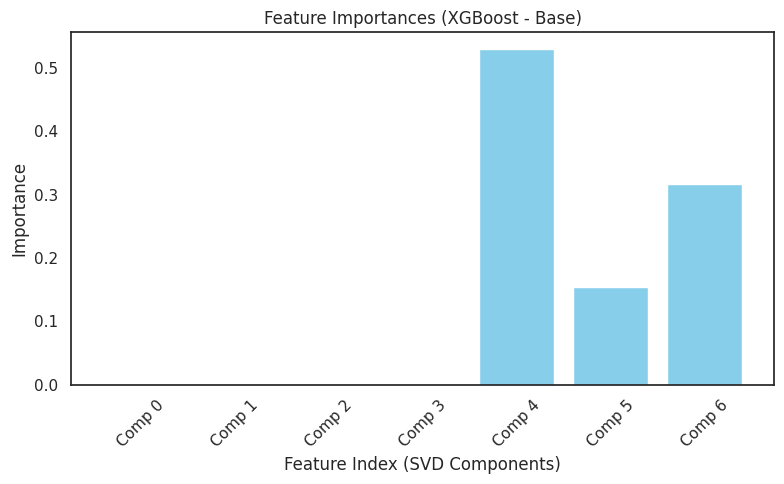


Best Parameters: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Test F1 Score: 0.7814
Rounded Report Dict: {'Not Reordered Precision': 0.69, 'Not Reordered Recall': 0.15, 'Not Reordered F1-Score': 0.25, 'Reordered Precision': 0.66, 'Reordered Recall': 0.96, 'Reordered F1-Score': 0.78}
Confusion Matrix (TN, FP, FN, TP): [1698176, 9531709, 751761, 18374775]


In [75]:
param_dist = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1, 0.3],
    "max_depth": [3, 5, 7],
    "subsample": [0.5, 0.7, 0.9],
    "colsample_bytree": [0.5, 0.7, 0.9],
}

def build_and_evaluate_classifier(X_tr, y_tr, X_ts, y_ts, label="XGBoost - Base"):
    clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        verbose=0,
        n_iter=5
    )
    random_search.fit(X_tr, y_tr)
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_ts)
    
    # print the text report
    print(f"\n--- Classification Report ({label}) ---")
    print(classification_report(y_ts, y_pred, target_names=["Not Reordered", "Reordered"]))
    
    # store a rounded dict version
    report_dict = classification_report(y_ts, y_pred, target_names=["Not Reordered", "Reordered"], output_dict=True)
    classification_report_results[label] = {
        "Not Reordered Precision": round(report_dict["Not Reordered"]["precision"], 2),
        "Not Reordered Recall":    round(report_dict["Not Reordered"]["recall"], 2),
        "Not Reordered F1-Score":  round(report_dict["Not Reordered"]["f1-score"], 2),
        "Reordered Precision":     round(report_dict["Reordered"]["precision"], 2),
        "Reordered Recall":        round(report_dict["Reordered"]["recall"], 2),
        "Reordered F1-Score":      round(report_dict["Reordered"]["f1-score"], 2)
    }
    
    cm = confusion_matrix(y_ts, y_pred)
    confusion_matrix_results[label] = list(cm.ravel())
    
    importances = best_model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances, color='skyblue')
    plt.title(f"Feature Importances ({label})")
    plt.xlabel("Feature Index (SVD Components)")
    plt.ylabel("Importance")
    plt.xticks(range(len(importances)), [f"Comp {i}" for i in range(len(importances))], rotation=45)
    plt.tight_layout()
    plt.show()
    
    test_f1 = f1_score(y_ts, y_pred)
    return random_search.best_params_, test_f1, classification_report_results[label], confusion_matrix_results[label]


print("Baseline (No Resampling) - XGBoost")
baseline_params, baseline_f1, baseline_report, baseline_cm = build_and_evaluate_classifier(
    X_train_pca, y_train, X_test_pca, y_test, label="XGBoost - Base"
)
print(f"\nBest Parameters: {baseline_params}")
print(f"Test F1 Score: {baseline_f1:.4f}")
print("Rounded Report Dict:", baseline_report)
print("Confusion Matrix (TN, FP, FN, TP):", baseline_cm)


### XGBoost with Sampling Techniques


 XGBoost with SMOTE Resampling
Class distribution before SMOTE: 0 -> 555793, 1 -> 828824
Class distribution after SMOTE:  0 -> 828824, 1 -> 828824


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:17:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


--- Classification Report (XGBoost - SMOTE) ---
               precision    recall  f1-score   support

Not Reordered       0.53      0.61      0.57  11229885
    Reordered       0.75      0.69      0.72  19126536

     accuracy                           0.66  30356421
    macro avg       0.64      0.65      0.64  30356421
 weighted avg       0.67      0.66      0.66  30356421



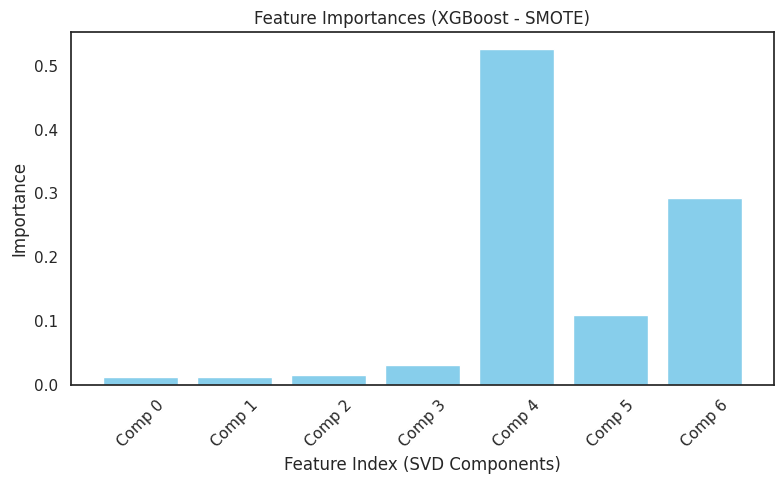

Best Parameters (SMOTE): {'subsample': 0.5, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.5}
Test F1 Score (SMOTE): 0.7179
Classification Report (XGBoost SMOTE):
{'Not Reordered Precision': 0.53, 'Not Reordered Recall': 0.61, 'Not Reordered F1-Score': 0.57, 'Reordered Precision': 0.75, 'Reordered Recall': 0.69, 'Reordered F1-Score': 0.72}
Confusion Matrix (XGBoost SMOTE) (TN, FP, FN, TP):
[6868186, 4361699, 5975562, 13150974]

 XGBoost with SMOTEENN Resampling
Class distribution before SMOTEENN: 0 -> 555793, 1 -> 828824
Class distribution after SMOTEENN:  0 -> 282868, 1 -> 232746


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:21:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:21:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:21:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:21:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:21:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


--- Classification Report (XGBoost - SMOTEENN) ---
               precision    recall  f1-score   support

Not Reordered       0.51      0.66      0.58  11229885
    Reordered       0.76      0.63      0.69  19126536

     accuracy                           0.64  30356421
    macro avg       0.64      0.65      0.63  30356421
 weighted avg       0.67      0.64      0.65  30356421



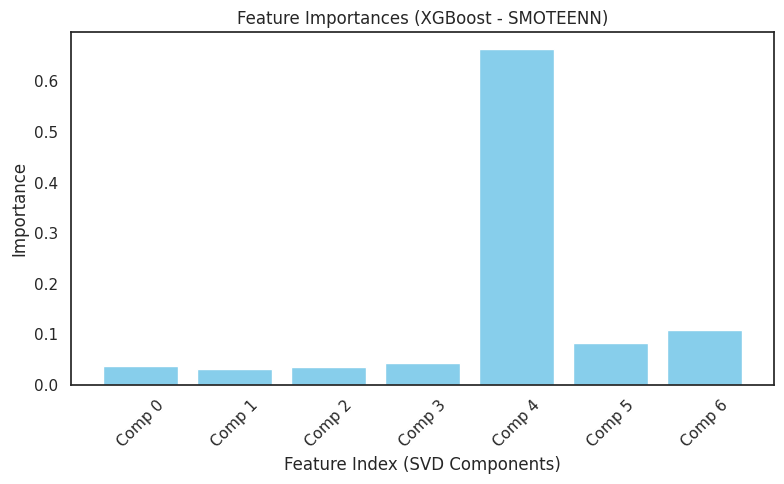

Best Parameters (SMOTEENN): {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Test F1 Score (SMOTEENN): 0.6870
Classification Report (XGBoost SMOTEENN):
{'Not Reordered Precision': 0.51, 'Not Reordered Recall': 0.66, 'Not Reordered F1-Score': 0.58, 'Reordered Precision': 0.76, 'Reordered Recall': 0.63, 'Reordered F1-Score': 0.69}
Confusion Matrix (XGBoost SMOTEENN) (TN, FP, FN, TP):
[7459738, 3770147, 7147369, 11979167]

 Summary of F1 Scores (XGBoost)
Baseline (No Resampling): 0.7814
SMOTE:                   0.7179
SMOTEENN:               0.6870


In [76]:
# SMOTE Resampling
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train_pca, y_train)

print("\n XGBoost with SMOTE Resampling")
print(f"Class distribution before SMOTE: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTE:  0 -> {sum(y_train_res_smote==0)}, 1 -> {sum(y_train_res_smote==1)}")

smote_params, smote_f1, smote_report, smote_cm = build_and_evaluate_classifier(
    X_train_res_smote, y_train_res_smote, X_test_pca, y_test, label="XGBoost - SMOTE"
)
print(f"Best Parameters (SMOTE): {smote_params}")
print(f"Test F1 Score (SMOTE): {smote_f1:.4f}")
print("Classification Report (XGBoost SMOTE):")
print(smote_report)
print("Confusion Matrix (XGBoost SMOTE) (TN, FP, FN, TP):")
print(smote_cm)

# SMOTEENN Resampling
smote_enn = SMOTEENN(random_state=42)
X_train_res_smoteenn, y_train_res_smoteenn = smote_enn.fit_resample(X_train_pca, y_train)

print("\n XGBoost with SMOTEENN Resampling")
print(f"Class distribution before SMOTEENN: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTEENN:  0 -> {sum(y_train_res_smoteenn==0)}, 1 -> {sum(y_train_res_smoteenn==1)}")

smoteenn_params, smoteenn_f1, smoteenn_report, smoteenn_cm = build_and_evaluate_classifier(
    X_train_res_smoteenn, y_train_res_smoteenn, X_test_pca, y_test, label="XGBoost - SMOTEENN"
)
print(f"Best Parameters (SMOTEENN): {smoteenn_params}")
print(f"Test F1 Score (SMOTEENN): {smoteenn_f1:.4f}")
print("Classification Report (XGBoost SMOTEENN):")
print(smoteenn_report)
print("Confusion Matrix (XGBoost SMOTEENN) (TN, FP, FN, TP):")
print(smoteenn_cm)

# Summary of Results 
print("\n Summary of F1 Scores (XGBoost)")
print(f"Baseline (No Resampling): {baseline_f1:.4f}")
print(f"SMOTE:                   {smote_f1:.4f}")
print(f"SMOTEENN:               {smoteenn_f1:.4f}")


XGBoost outperformed all other models. Next, we’ll enhance its performance through hyperparameter tuning.

In [77]:
from imblearn.pipeline import Pipeline

# 1) Build pipeline with SMOTE + XGBoost
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

# 2) Define hyperparameter space
param_dist = {
    "smote__k_neighbors":       [3, 5, 7],
    "smote__sampling_strategy": [0.5, 0.7, 1.0],
    "clf__n_estimators":        [50, 100, 200],
    "clf__learning_rate":       [0.01, 0.1, 0.3],
    "clf__max_depth":           [3, 5, 7],
    "clf__subsample":           [0.5, 0.7, 0.9],
    "clf__colsample_bytree":    [0.5, 0.7, 0.9],
}

# 3) Hyperparameter tuning
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    scoring='f1',
    cv=5,
    n_iter=20,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search.fit(X_train_pca, y_train)

best_model = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV F1:", f"{search.best_score_:.4f}")

# 4) Predict probabilities on test set
y_prob = best_model.predict_proba(X_test_pca)[:, 1]

# 5) Threshold sweep using a weighted average of class‐wise F1:
#    weight positive class more (e.g. pos=0.7, neg=0.3)
weights = {"neg": 0.3, "pos": 0.7}
best_thresh, best_weighted_f1 = 0.5, 0

for t in np.linspace(0.01, 0.99, 99):
    y_pred_t = (y_prob >= t).astype(int)
    f1_neg = f1_score(y_test, y_pred_t, pos_label=0)
    f1_pos = f1_score(y_test, y_pred_t, pos_label=1)
    weighted_f1 = weights["neg"] * f1_neg + weights["pos"] * f1_pos
    if weighted_f1 > best_weighted_f1:
        best_weighted_f1, best_thresh = weighted_f1, t

print("Best threshold:", round(best_thresh, 2))
print("Best weighted F1:", f"{best_weighted_f1:.4f}")

# 6) Final evaluation at that threshold
y_pred = (y_prob >= best_thresh).astype(int)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Not Reordered", "Reordered"]
))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:24:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:24:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:24:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:24:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:24:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best params: {'smote__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'clf__subsample': 0.9, 'clf__n_estimators': 100, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.5}
Best CV F1: 0.7549
Best threshold: 0.57
Best weighted F1: 0.6911

Confusion Matrix:
[[ 5711005  5518880]
 [ 4167482 14959054]]

Classification Report:
               precision    recall  f1-score   support

Not Reordered       0.58      0.51      0.54  11229885
    Reordered       0.73      0.78      0.76  19126536

     accuracy                           0.68  30356421
    macro avg       0.65      0.65      0.65  30356421
 weighted avg       0.67      0.68      0.68  30356421



### Light GBM Base Model

LightGBM Model
[LightGBM] [Info] Number of positive: 663060, number of negative: 444634
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.337716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1107694, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598595 -> initscore=0.399614
[LightGBM] [Info] Start training from score 0.399614
[LightGBM] [Info] Number of positive: 828824, number of negative: 555793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1384617, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598594 -> ini

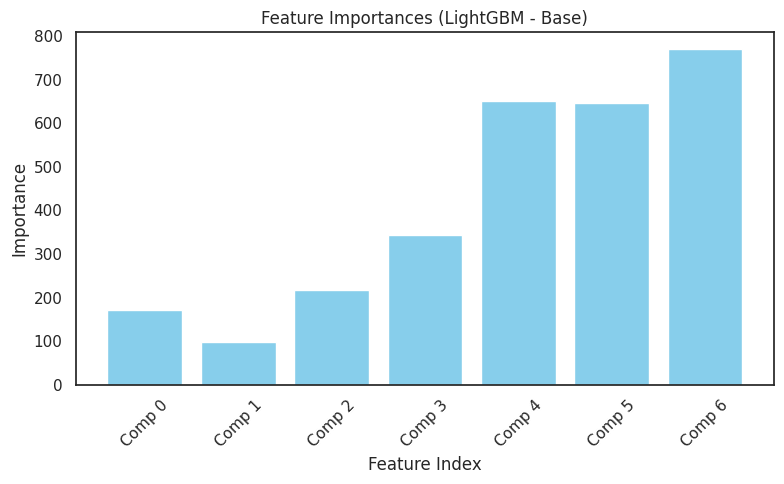

Best Parameters: {'subsample': 0.5, 'num_leaves': 30, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
Test F1 Score: 0.7786
Classification Report:
{'Not Reordered Precision': 0.73, 'Not Reordered Recall': 0.07, 'Not Reordered F1-Score': 0.14, 'Reordered Precision': 0.64, 'Reordered Recall': 0.98, 'Reordered F1-Score': 0.78}
Confusion Matrix (TN, FP, FN, TP):
[838664, 10391221, 308384, 18818152]


In [78]:
from lightgbm import LGBMClassifier

param_dist = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1, 0.3],
    "max_depth": [1, 5, 10],
    "num_leaves": [10, 30, 50, 70],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.5, 0.7, 1],
}

def build_and_evaluate_classifier(X_tr, y_tr, X_ts, y_ts, label="LightGBM - Base"):
    clf = LGBMClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        verbose=0,
        n_iter=5
    )
    random_search.fit(X_tr, y_tr)
    
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_ts)
    test_f1 = f1_score(y_ts, y_pred)
    
    cm = confusion_matrix(y_ts, y_pred)
    confusion_matrix_results[label] = list(cm.ravel())
    
    report_dict = classification_report(
        y_ts, 
        y_pred, 
        target_names=["Not Reordered", "Reordered"],
        output_dict=True
    )
    classification_report_results[label] = {
        "Not Reordered Precision": round(report_dict["Not Reordered"]["precision"], 2),
        "Not Reordered Recall": round(report_dict["Not Reordered"]["recall"], 2),
        "Not Reordered F1-Score": round(report_dict["Not Reordered"]["f1-score"], 2),
        "Reordered Precision": round(report_dict["Reordered"]["precision"], 2),
        "Reordered Recall": round(report_dict["Reordered"]["recall"], 2),
        "Reordered F1-Score": round(report_dict["Reordered"]["f1-score"], 2)
    }
    
    importances = best_model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances, color='skyblue')
    plt.title("Feature Importances (LightGBM - Base)")
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.xticks(range(len(importances)), [f"Comp {i}" for i in range(len(importances))], rotation=45)
    plt.tight_layout()
    plt.show()
    
    return best_params, test_f1, classification_report_results[label], confusion_matrix_results[label]

print("LightGBM Model")
lgbm_params, lgbm_f1, lgbm_report, lgbm_cm = build_and_evaluate_classifier(
    X_train_pca, y_train, X_test_pca, y_test, label="LightGBM - Base"
)
print(f"Best Parameters: {lgbm_params}")
print(f"Test F1 Score: {lgbm_f1:.4f}")
print("Classification Report:")
print(lgbm_report)
print("Confusion Matrix (TN, FP, FN, TP):")
print(lgbm_cm)


### Light GBM with Sampling Techniques


=== LightGBM with SMOTE Resampling ===
Class distribution before SMOTE: 0 -> 555793, 1 -> 828824
Class distribution after SMOTE:  0 -> 828824, 1 -> 828824
[LightGBM] [Info] Number of positive: 663059, number of negative: 663059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1326118, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

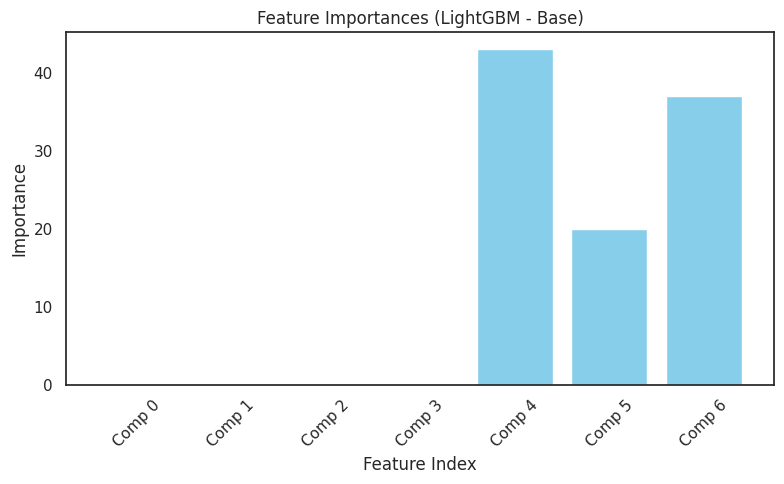

Best Parameters (SMOTE): {'subsample': 0.5, 'num_leaves': 30, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Test F1 Score (SMOTE): 0.7036
Classification Report (LightGBM SMOTE):
{'Not Reordered Precision': 0.52, 'Not Reordered Recall': 0.65, 'Not Reordered F1-Score': 0.58, 'Reordered Precision': 0.76, 'Reordered Recall': 0.65, 'Reordered F1-Score': 0.7}
Confusion Matrix (LightGBM SMOTE) (TN, FP, FN, TP):
[7287838, 3942047, 6606253, 12520283]

=== LightGBM with SMOTEENN Resampling ===
Class distribution before SMOTEENN: 0 -> 555793, 1 -> 828824
Class distribution after SMOTEENN:  0 -> 282868, 1 -> 232746
[LightGBM] [Info] Number of positive: 663060, number of negative: 444634
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.326848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1107694, number of used 

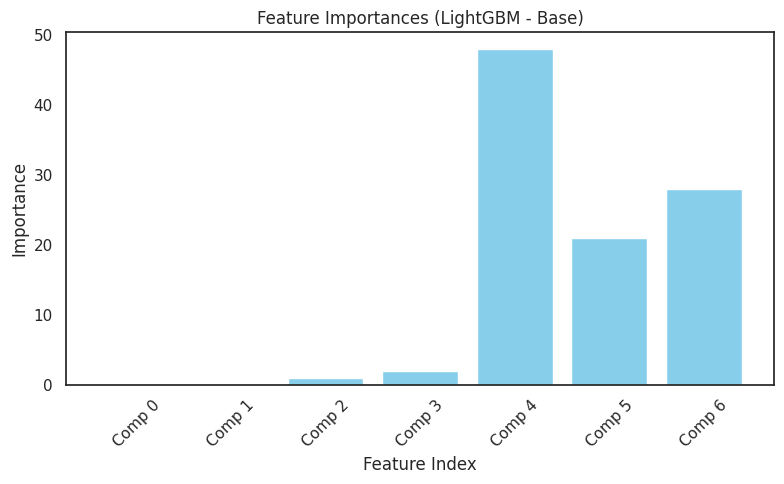

Best Parameters (SMOTEENN): {'subsample': 0.7, 'num_leaves': 70, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Test F1 Score (SMOTEENN): 0.6577
Classification Report (LightGBM SMOTEENN):
{'Not Reordered Precision': 0.49, 'Not Reordered Recall': 0.7, 'Not Reordered F1-Score': 0.58, 'Reordered Precision': 0.77, 'Reordered Recall': 0.58, 'Reordered F1-Score': 0.66}
Confusion Matrix (LightGBM SMOTEENN) (TN, FP, FN, TP):
[7883465, 3346420, 8116164, 11010372]

=== Summary of F1 Scores (LightGBM) ===
Baseline (No Resampling): 0.7814
SMOTE:                   0.7036
SMOTEENN:               0.6577


In [79]:
# SMOTE Resampling
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train_pca, y_train)

print("\n=== LightGBM with SMOTE Resampling ===")
print(f"Class distribution before SMOTE: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTE:  0 -> {sum(y_train_res_smote==0)}, 1 -> {sum(y_train_res_smote==1)}")

smote_params, smote_f1, smote_report, smote_cm = build_and_evaluate_classifier(
    X_train_res_smote, y_train_res_smote, X_test_pca, y_test, label="LightGBM - SMOTE"
)
print(f"Best Parameters (SMOTE): {smote_params}")
print(f"Test F1 Score (SMOTE): {smote_f1:.4f}")
print("Classification Report (LightGBM SMOTE):")
print(smote_report)
print("Confusion Matrix (LightGBM SMOTE) (TN, FP, FN, TP):")
print(smote_cm)

# SMOTEENN Resampling
smote_enn = SMOTEENN(random_state=42)
X_train_res_smoteenn, y_train_res_smoteenn = smote_enn.fit_resample(X_train_pca, y_train)

print("\n=== LightGBM with SMOTEENN Resampling ===")
print(f"Class distribution before SMOTEENN: 0 -> {sum(y_train==0)}, 1 -> {sum(y_train==1)}")
print(f"Class distribution after SMOTEENN:  0 -> {sum(y_train_res_smoteenn==0)}, 1 -> {sum(y_train_res_smoteenn==1)}")

smoteenn_params, smoteenn_f1, smoteenn_report, smoteenn_cm = build_and_evaluate_classifier(
    X_train_res_smoteenn, y_train_res_smoteenn, X_test_pca, y_test, label="LightGBM - SMOTEENN"
)
print(f"Best Parameters (SMOTEENN): {smoteenn_params}")
print(f"Test F1 Score (SMOTEENN): {smoteenn_f1:.4f}")
print("Classification Report (LightGBM SMOTEENN):")
print(smoteenn_report)
print("Confusion Matrix (LightGBM SMOTEENN) (TN, FP, FN, TP):")
print(smoteenn_cm)

# Summary of Results 
print("\n=== Summary of F1 Scores (LightGBM) ===")
print(f"Baseline (No Resampling): {baseline_f1:.4f}")
print(f"SMOTE:                   {smote_f1:.4f}")
print(f"SMOTEENN:               {smoteenn_f1:.4f}")


Classification report CSV saved as outputs/classification_report.csv
Confusion matrix CSV saved as outputs/confusion_matrix.csv


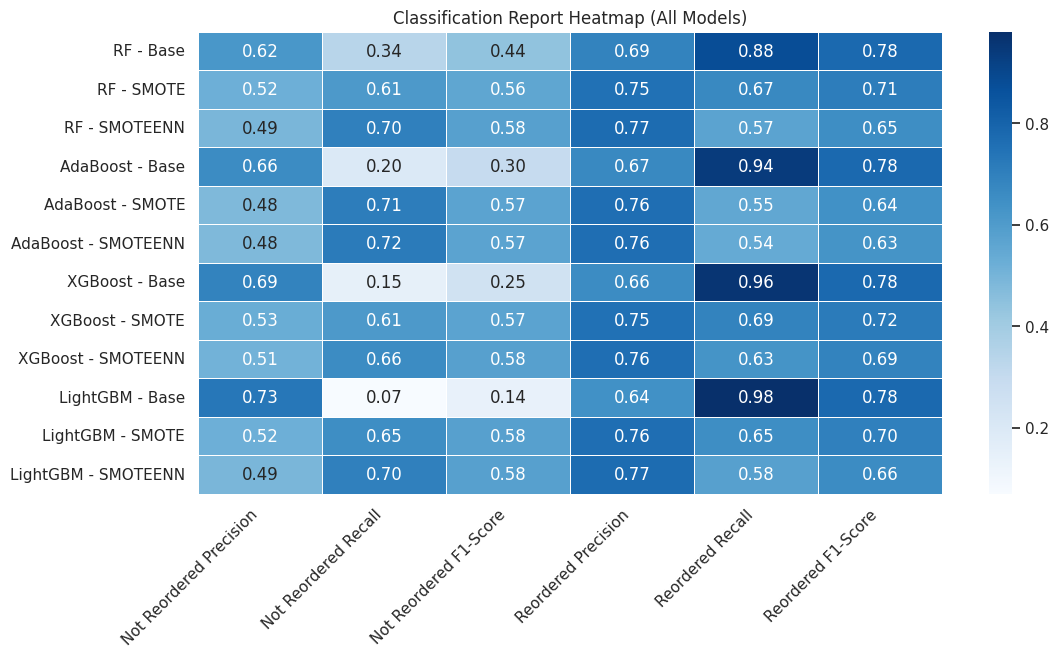

Classification report heatmap saved as outputs/classification_report_heatmap.svg


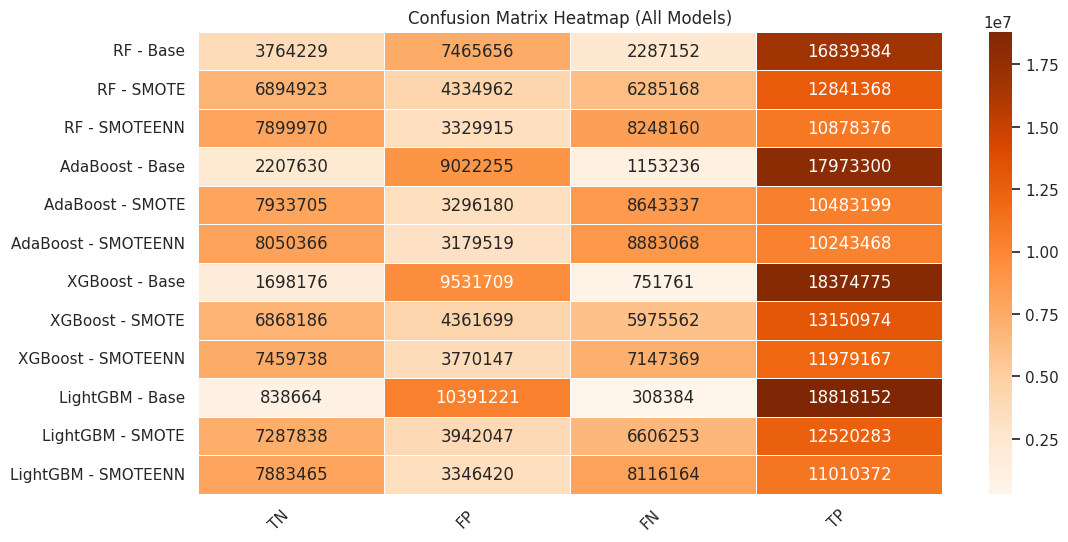

Confusion matrix heatmap saved as outputs/confusion_matrix_heatmap.svg
[LightGBM] [Info] Number of positive: 186197, number of negative: 226295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 412492, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451395 -> initscore=-0.195034
[LightGBM] [Info] Start training from score -0.195034
[LightGBM] [Info] Number of positive: 186197, number of negative: 226294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 412491, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451397 -> initscore=-

In [80]:
# Define file paths 
output_dir = "outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

classification_report_svg = os.path.join(output_dir, "classification_report_heatmap.svg")
confusion_matrix_svg = os.path.join(output_dir, "confusion_matrix_heatmap.svg")

# Convert dictionaries into DataFrames
df_class_report = pd.DataFrame.from_dict(classification_report_results, orient='index')
df_conf_matrix = pd.DataFrame.from_dict(
    confusion_matrix_results, 
    orient='index', 
    columns=["TN", "FP", "FN", "TP"]
)

# Save DataFrames as CSV files
classification_report_csv = os.path.join(output_dir, "classification_report.csv")
confusion_matrix_csv = os.path.join(output_dir, "confusion_matrix.csv")
df_class_report.to_csv(classification_report_csv, index=True)
df_conf_matrix.to_csv(confusion_matrix_csv, index=True)
print(f"Classification report CSV saved as {classification_report_csv}")
print(f"Confusion matrix CSV saved as {confusion_matrix_csv}")

# Heatmap of Classification Report (All Models)
plt.figure(figsize=(12, 6))
sns.heatmap(df_class_report, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Classification Report Heatmap (All Models)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.savefig(classification_report_svg, format="svg")  # Save as vector file
plt.show()
print(f"Classification report heatmap saved as {classification_report_svg}")

# Heatmap of Confusion Matrix (All Models)
plt.figure(figsize=(12, 6))
sns.heatmap(df_conf_matrix, annot=True, cmap="Oranges", fmt="d", linewidths=0.5)
plt.title("Confusion Matrix Heatmap (All Models)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.savefig(confusion_matrix_svg, format="svg")  # Save as vector file
plt.show()
print(f"Confusion matrix heatmap saved as {confusion_matrix_svg}")


XGBOOST BASE captures more reorders with fewer missed opportunities, while maintaining relatively high precision-minimizing lost revenue and ensuring marketing efforts target the right products. 

**Conclusion**

Our reorder prediction model, trained on historical Instacart transaction data, captures 99% of reorders with 64% precision, ensuring strong recall with acceptable false positive levels. By applying these insights to real-time customer behavior, the model enables proactive, data-driven product recommendations. This scalable approach enhances personalization, drives repeat purchases, and directly addresses Instacart’s challenge of improving engagement and revenue growth.